# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [2]:
! pip install Pillow

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [4]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!ls MNIST

processed  raw


In [6]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-6-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [7]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

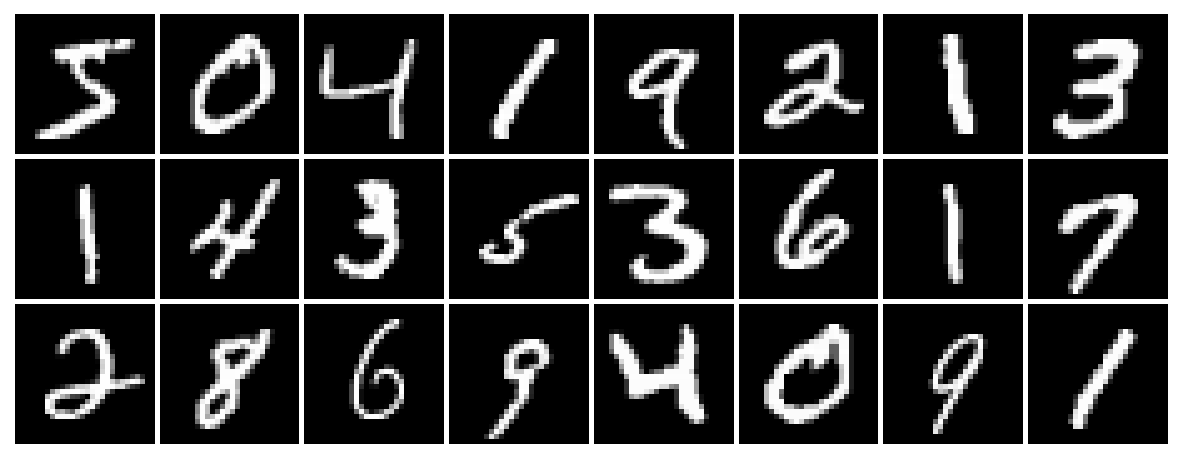

In [8]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


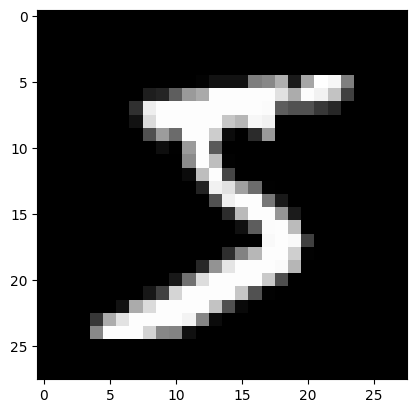

In [9]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [10]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [11]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.0292,  0.3252,  0.1529, -0.1649, -0.2574, -0.1305, -0.0777,  0.0461,
         -0.1961, -0.1007],
        [ 0.0987,  0.1424,  0.0599,  0.0855,  0.0530, -0.0629,  0.1147,  0.0585,
         -0.0851, -0.1358],
        [-0.0215,  0.2132, -0.0124, -0.0323, -0.2618,  0.1465, -0.1348,  0.0324,
         -0.4387,  0.1216],
        [ 0.0594, -0.1485, -0.0591, -0.0333, -0.0676, -0.0954,  0.1696,  0.3406,
         -0.0476, -0.0527],
        [ 0.0745,  0.0444,  0.0440,  0.2039, -0.1779,  0.1226,  0.0311,  0.3202,
         -0.0167, -0.0471]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [12]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.1 MB/s eta 0:00:00
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-rnol089y
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-rnol089y
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=85f8650d57b611c7a8cb7e8ff2ad61655bea8a1376eac3c214c6f9f05975b580
  Stored in directory: /tmp/pip-ephem-wheel-cache-goxbmxuo/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [14]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss
# p = make_dot(loss, dict(model.named_parameters()))
# p

tensor(2.3643, grad_fn=<NllLossBackward0>)

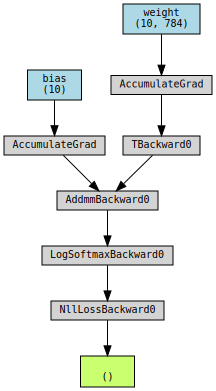

In [15]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

weights: torch.Size([10, 784])


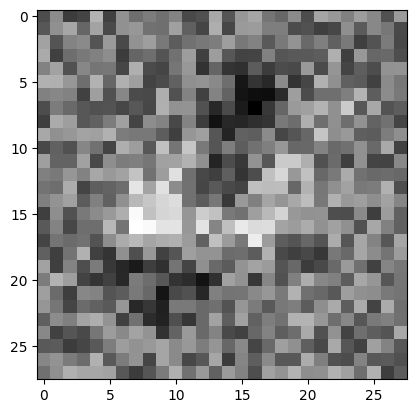

Epoch Accuracy: 0.739
weights: torch.Size([10, 784])


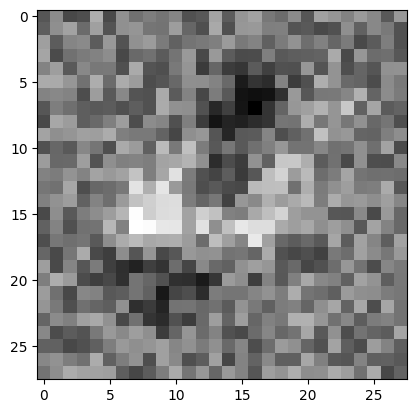

Epoch Accuracy: 0.773
weights: torch.Size([10, 784])


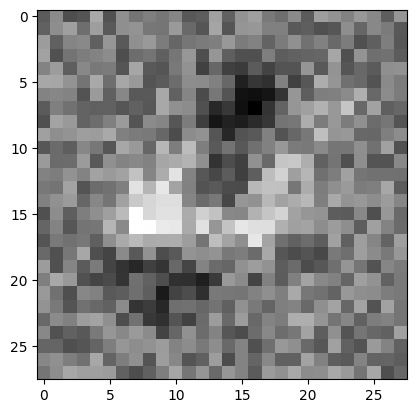

Epoch Accuracy: 0.812
weights: torch.Size([10, 784])


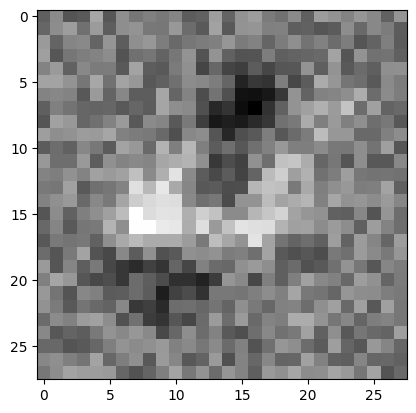

Epoch Accuracy: 0.811
weights: torch.Size([10, 784])


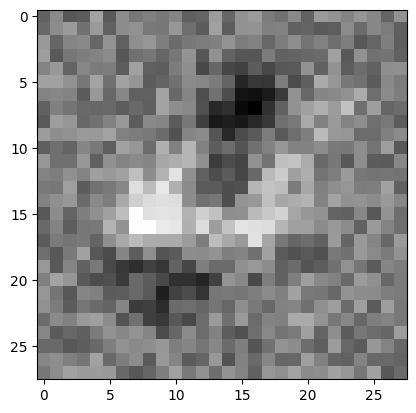

Epoch Accuracy: 0.835
weights: torch.Size([10, 784])


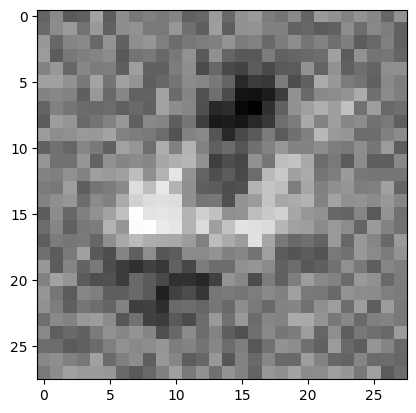

Epoch Accuracy: 0.838
weights: torch.Size([10, 784])


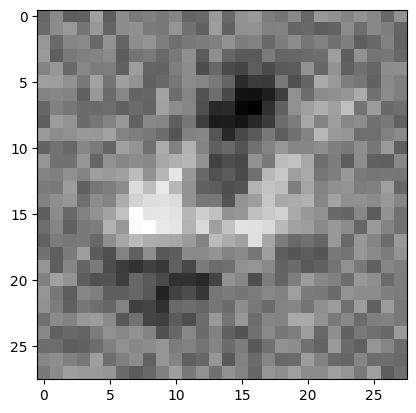

Epoch Accuracy: 0.846
weights: torch.Size([10, 784])


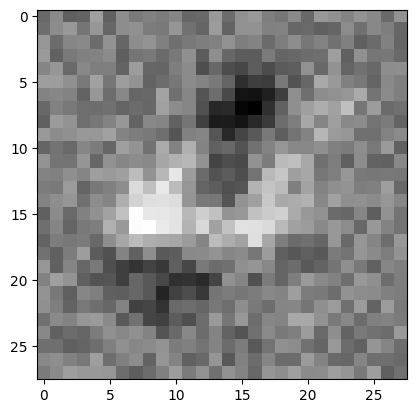

Epoch Accuracy: 0.847
weights: torch.Size([10, 784])


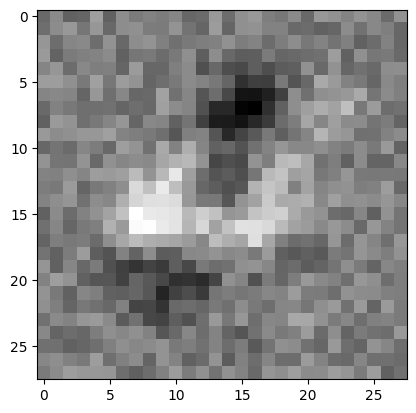

Epoch Accuracy: 0.854
weights: torch.Size([10, 784])


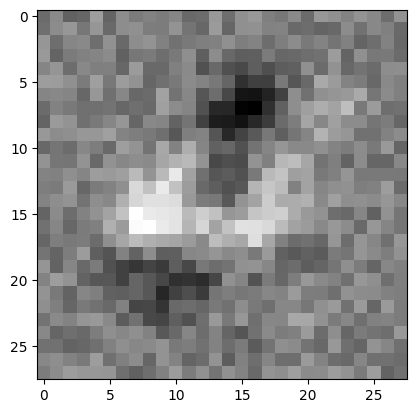

Epoch Accuracy: 0.856
weights: torch.Size([10, 784])


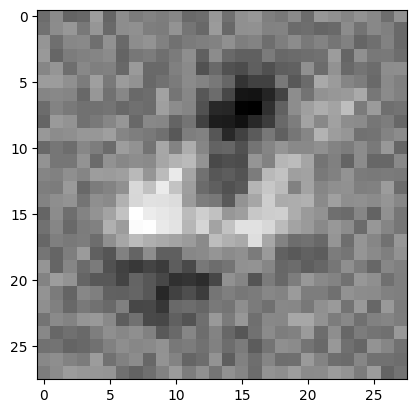

Epoch Accuracy: 0.861
weights: torch.Size([10, 784])


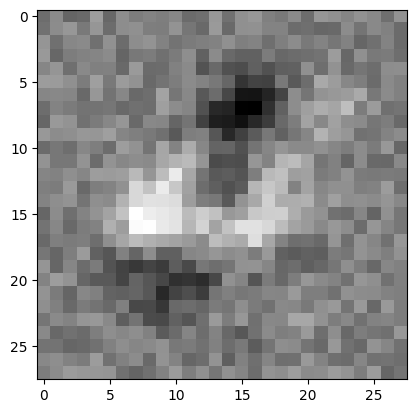

Epoch Accuracy: 0.862
weights: torch.Size([10, 784])


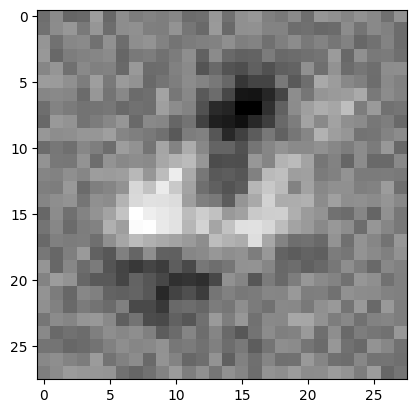

Epoch Accuracy: 0.863
weights: torch.Size([10, 784])


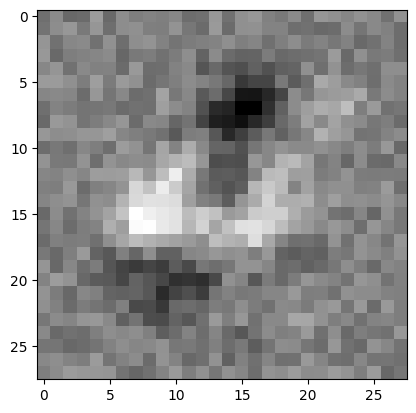

Epoch Accuracy: 0.869
weights: torch.Size([10, 784])


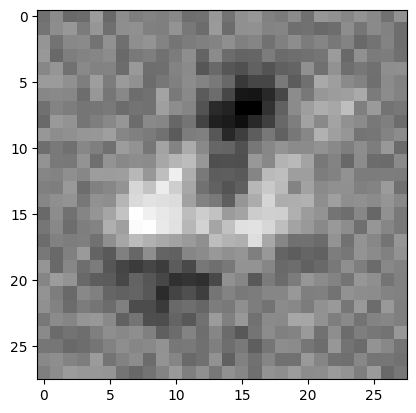

Epoch Accuracy: 0.872
weights: torch.Size([10, 784])


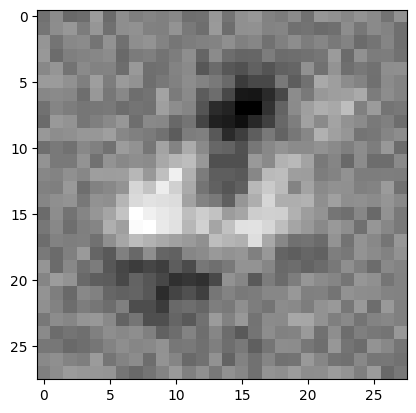

Epoch Accuracy: 0.871
weights: torch.Size([10, 784])


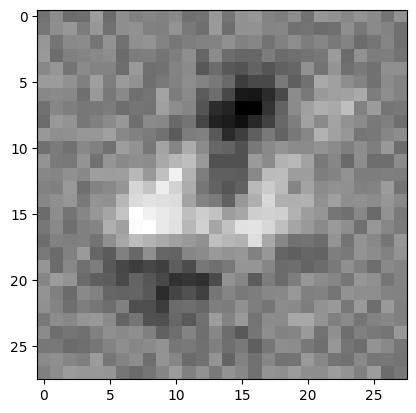

Epoch Accuracy: 0.874
weights: torch.Size([10, 784])


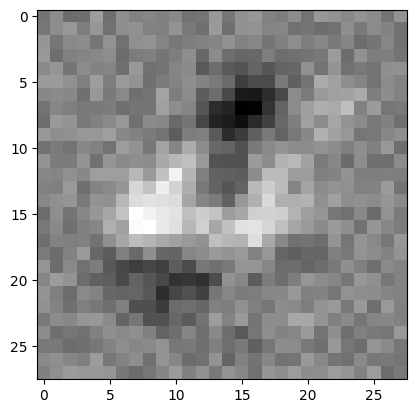

Epoch Accuracy: 0.877
weights: torch.Size([10, 784])


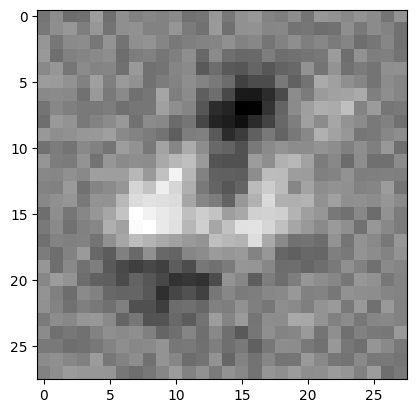

Epoch Accuracy: 0.878
weights: torch.Size([10, 784])


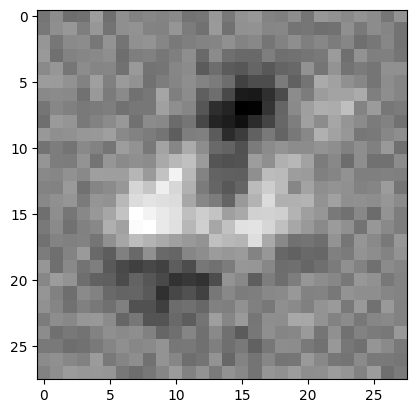

Epoch Accuracy: 0.879
weights: torch.Size([10, 784])


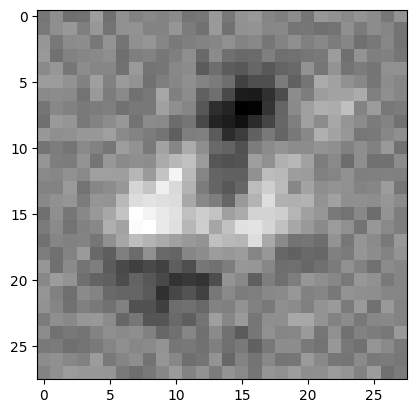

Epoch Accuracy: 0.88
weights: torch.Size([10, 784])


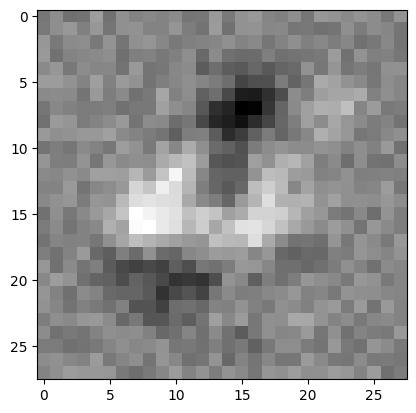

Epoch Accuracy: 0.885
weights: torch.Size([10, 784])


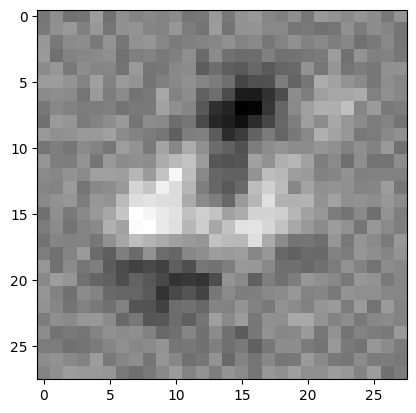

Epoch Accuracy: 0.89
weights: torch.Size([10, 784])


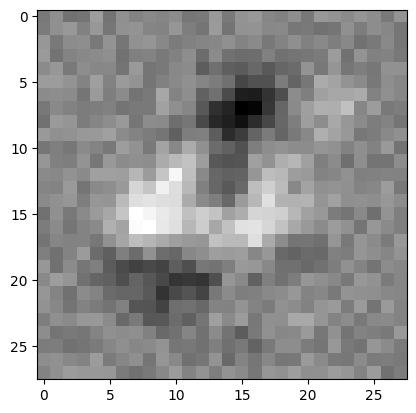

Epoch Accuracy: 0.893
weights: torch.Size([10, 784])


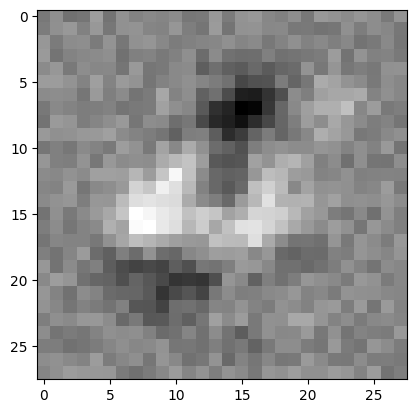

Epoch Accuracy: 0.894
weights: torch.Size([10, 784])


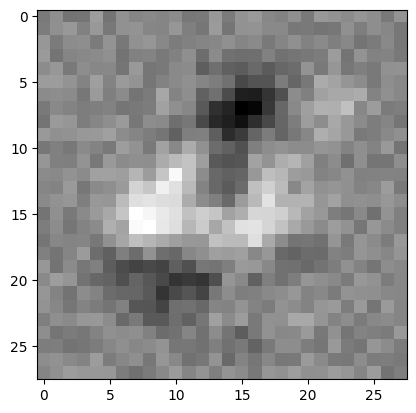

Epoch Accuracy: 0.895
weights: torch.Size([10, 784])


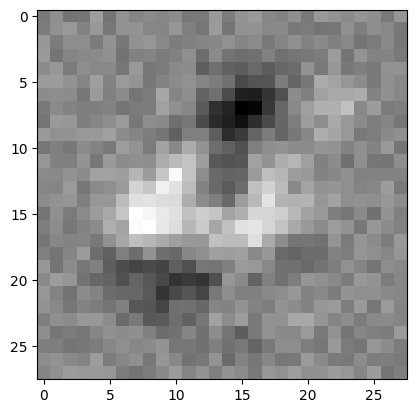

Epoch Accuracy: 0.9
weights: torch.Size([10, 784])


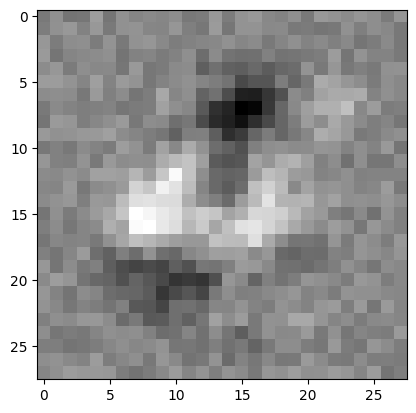

Epoch Accuracy: 0.902
weights: torch.Size([10, 784])


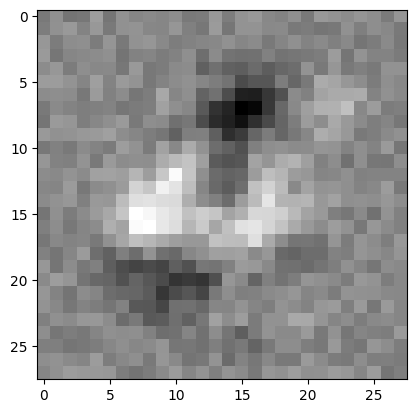

Epoch Accuracy: 0.903
weights: torch.Size([10, 784])


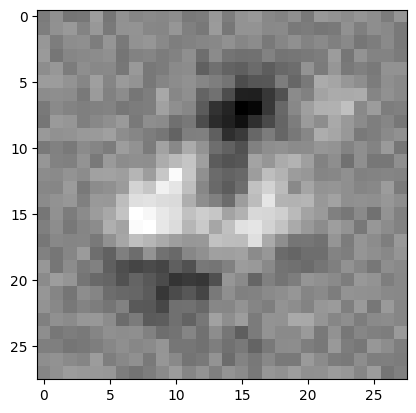

Epoch Accuracy: 0.903
weights: torch.Size([10, 784])


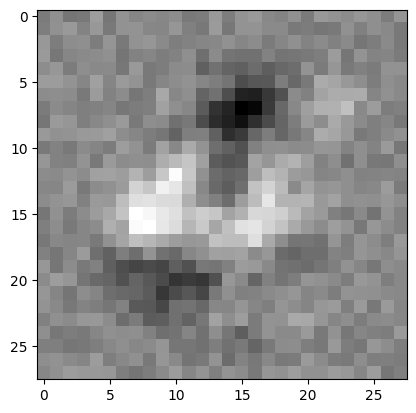

Epoch Accuracy: 0.903
weights: torch.Size([10, 784])


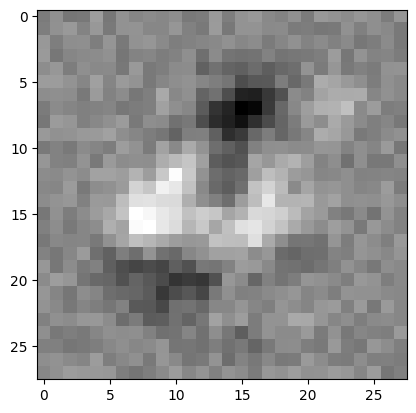

Epoch Accuracy: 0.903
weights: torch.Size([10, 784])


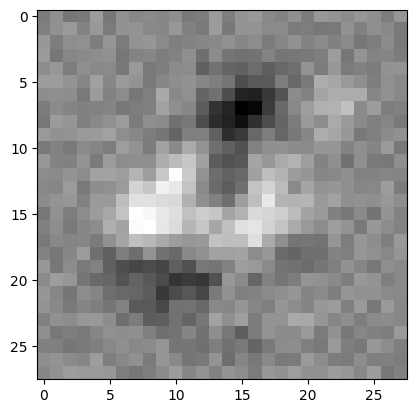

Epoch Accuracy: 0.905
weights: torch.Size([10, 784])


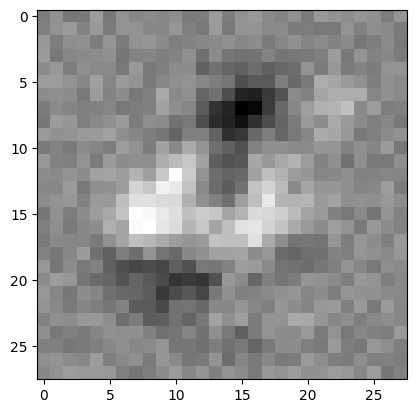

Epoch Accuracy: 0.906
weights: torch.Size([10, 784])


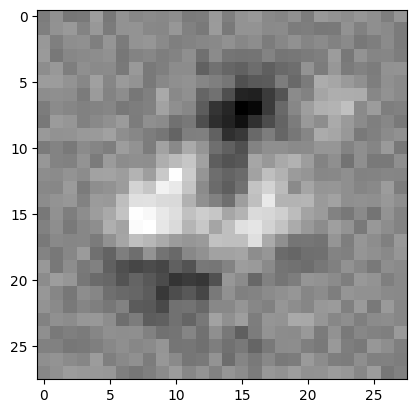

Epoch Accuracy: 0.907
weights: torch.Size([10, 784])


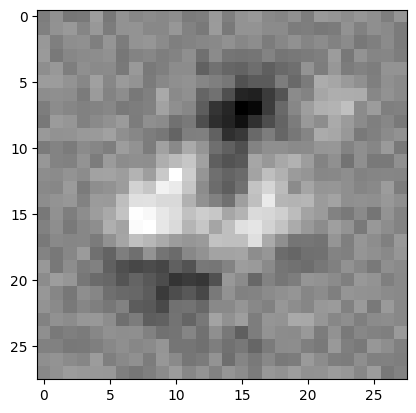

Epoch Accuracy: 0.908
weights: torch.Size([10, 784])


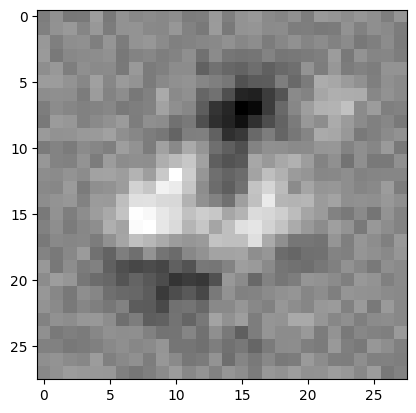

Epoch Accuracy: 0.908
weights: torch.Size([10, 784])


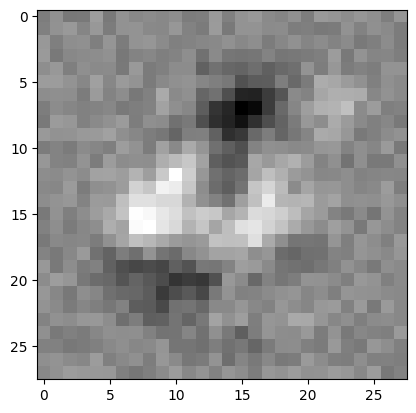

Epoch Accuracy: 0.909
weights: torch.Size([10, 784])


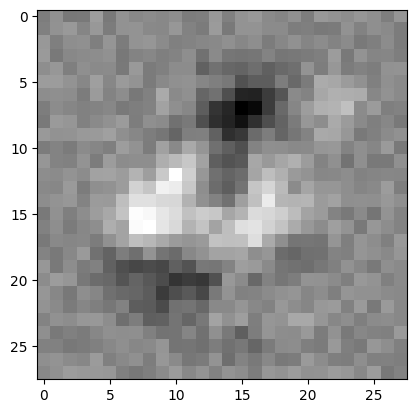

Epoch Accuracy: 0.909
weights: torch.Size([10, 784])


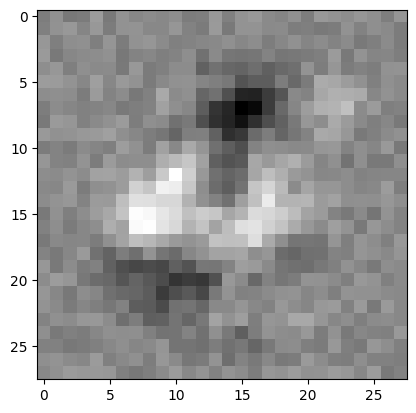

Epoch Accuracy: 0.909
weights: torch.Size([10, 784])


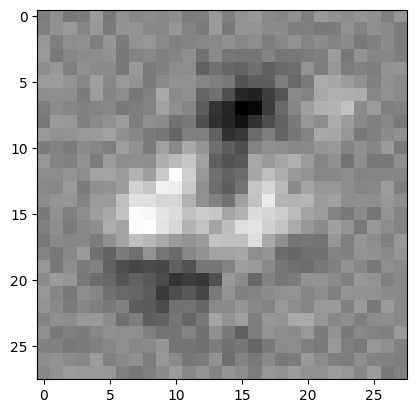

Epoch Accuracy: 0.91
weights: torch.Size([10, 784])


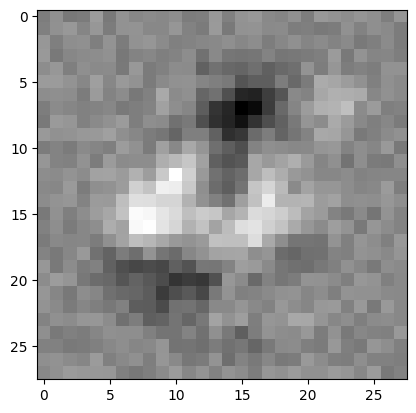

Epoch Accuracy: 0.912
weights: torch.Size([10, 784])


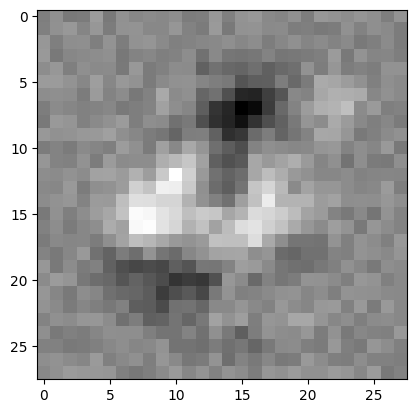

Epoch Accuracy: 0.912
weights: torch.Size([10, 784])


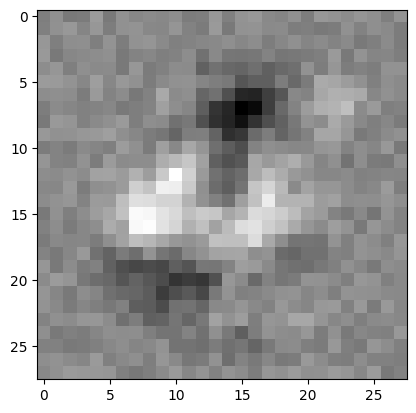

Epoch Accuracy: 0.913
weights: torch.Size([10, 784])


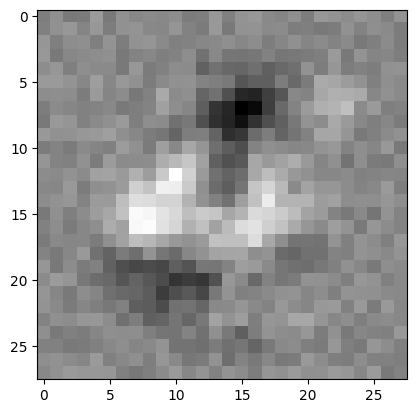

Epoch Accuracy: 0.915
weights: torch.Size([10, 784])


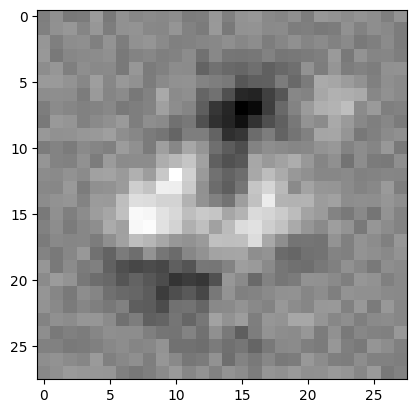

Epoch Accuracy: 0.916
weights: torch.Size([10, 784])


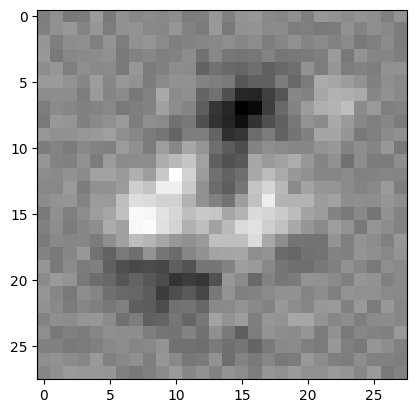

Epoch Accuracy: 0.916
weights: torch.Size([10, 784])


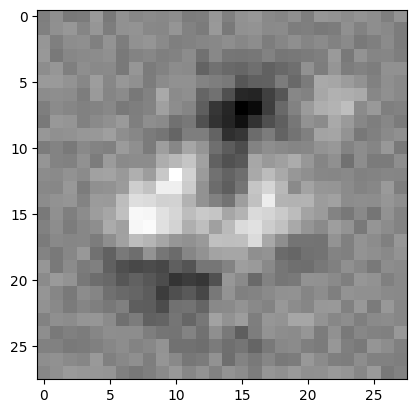

Epoch Accuracy: 0.918
weights: torch.Size([10, 784])


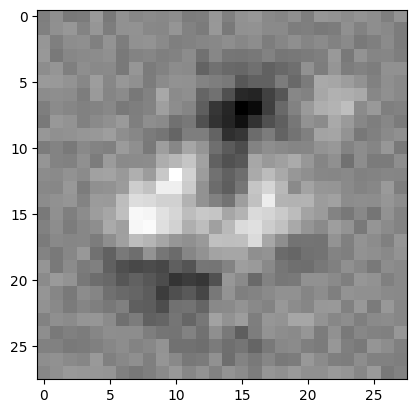

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


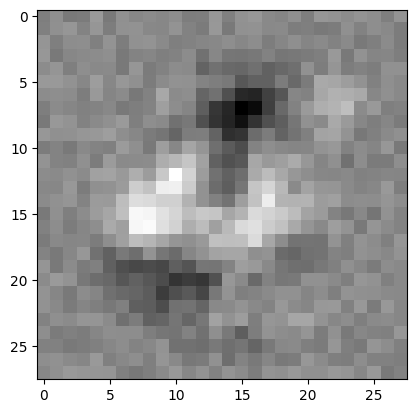

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


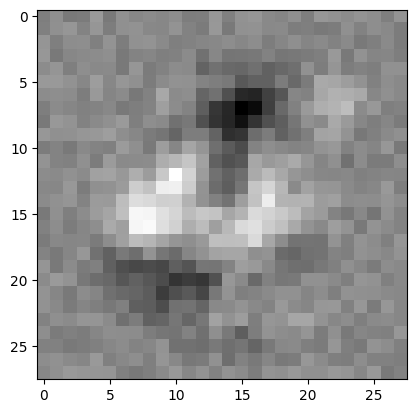

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


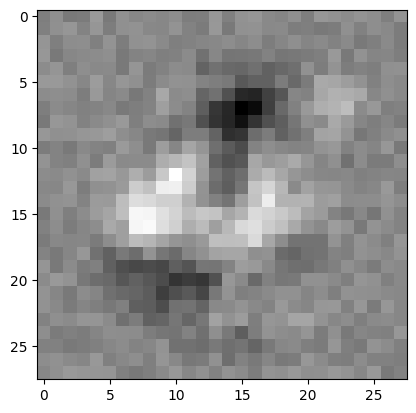

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


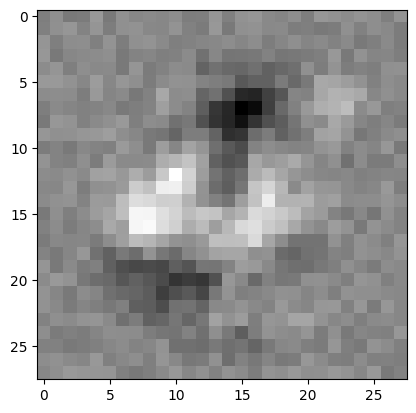

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


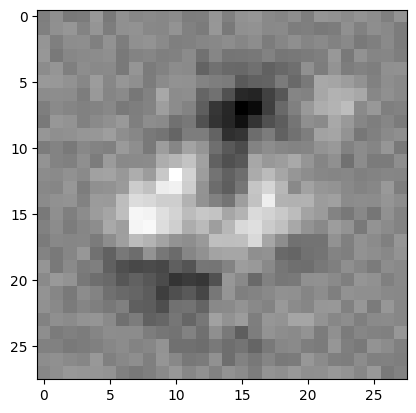

Epoch Accuracy: 0.922
weights: torch.Size([10, 784])


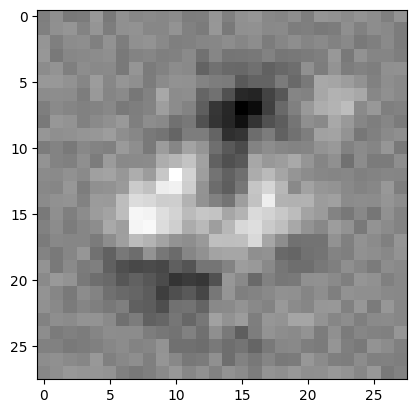

Epoch Accuracy: 0.924
weights: torch.Size([10, 784])


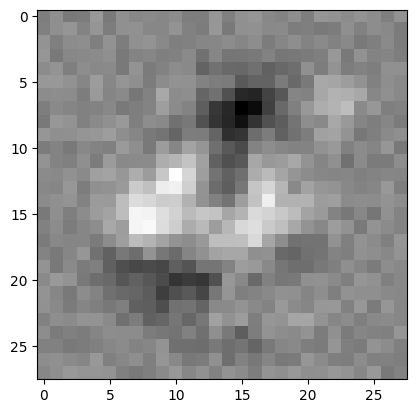

Epoch Accuracy: 0.924
weights: torch.Size([10, 784])


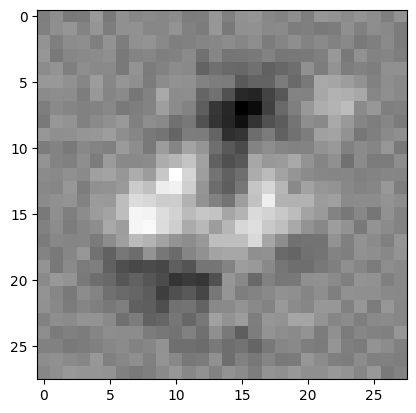

Epoch Accuracy: 0.924
weights: torch.Size([10, 784])


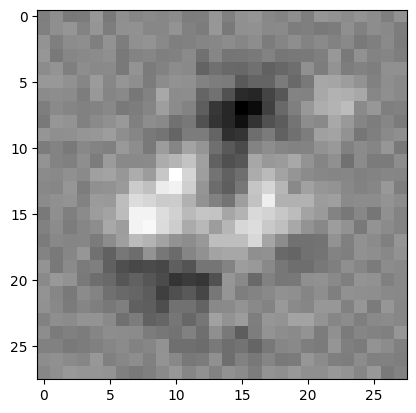

Epoch Accuracy: 0.924
weights: torch.Size([10, 784])


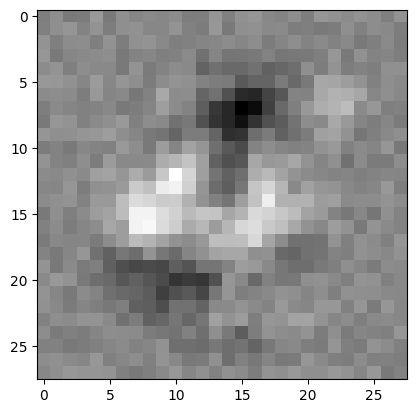

Epoch Accuracy: 0.925
weights: torch.Size([10, 784])


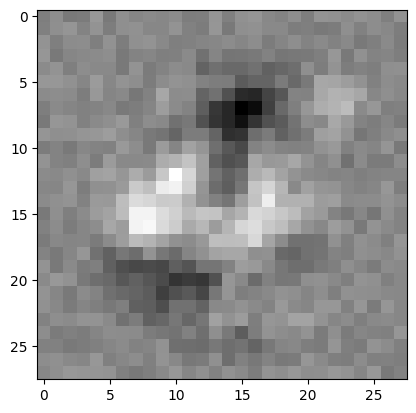

Epoch Accuracy: 0.926
weights: torch.Size([10, 784])


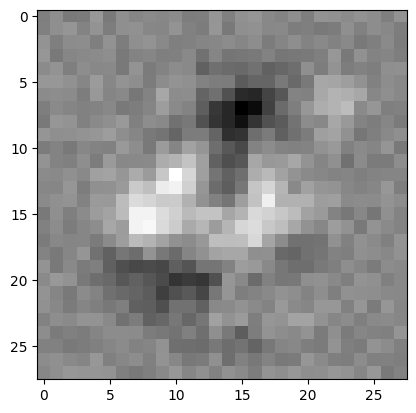

Epoch Accuracy: 0.926
weights: torch.Size([10, 784])


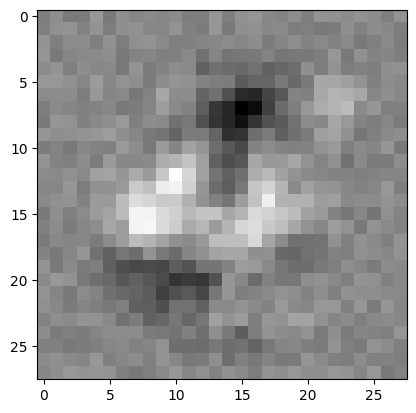

Epoch Accuracy: 0.927
weights: torch.Size([10, 784])


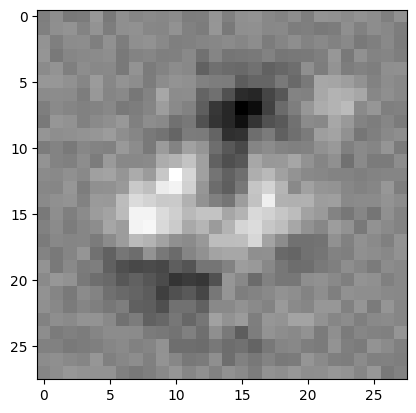

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


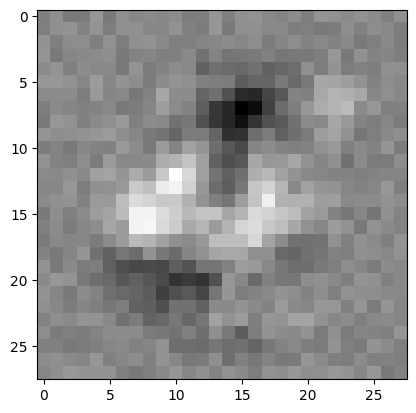

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


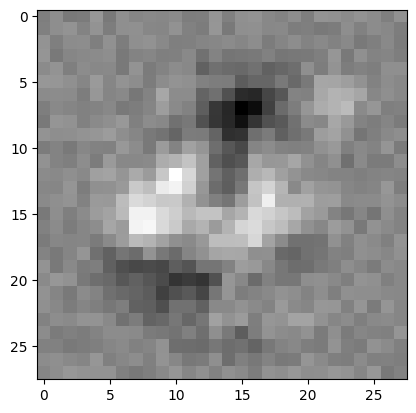

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


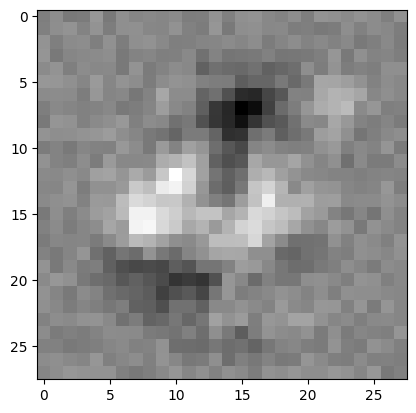

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


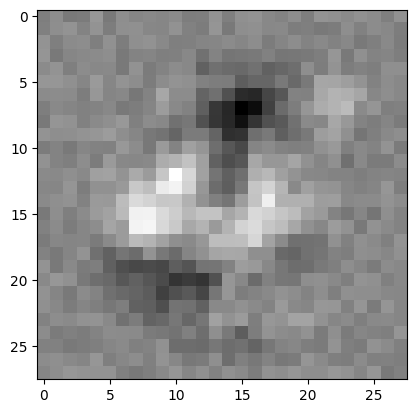

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


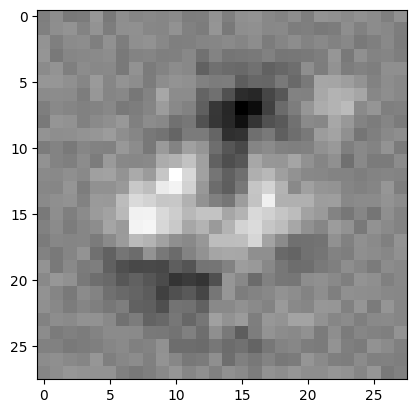

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


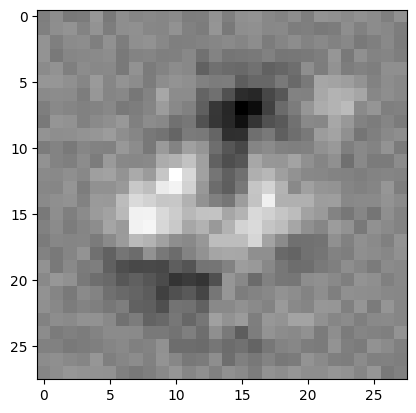

Epoch Accuracy: 0.929
weights: torch.Size([10, 784])


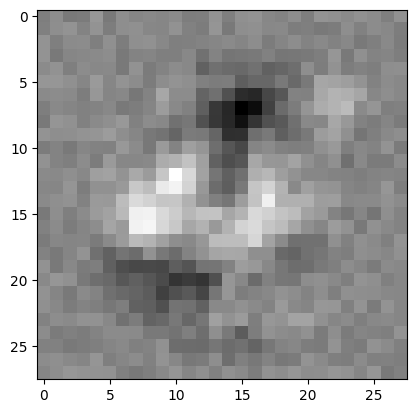

Epoch Accuracy: 0.93
weights: torch.Size([10, 784])


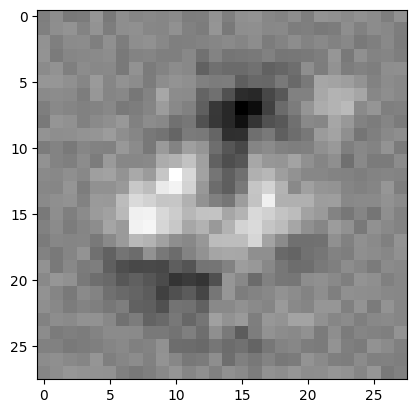

Epoch Accuracy: 0.93
weights: torch.Size([10, 784])


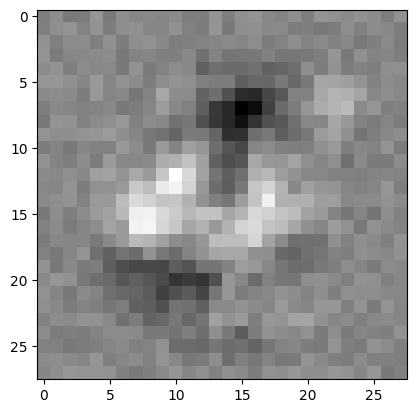

Epoch Accuracy: 0.93
weights: torch.Size([10, 784])


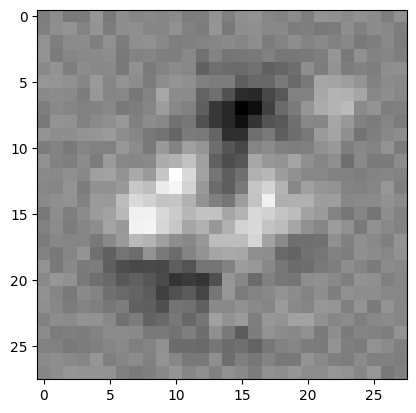

Epoch Accuracy: 0.93
weights: torch.Size([10, 784])


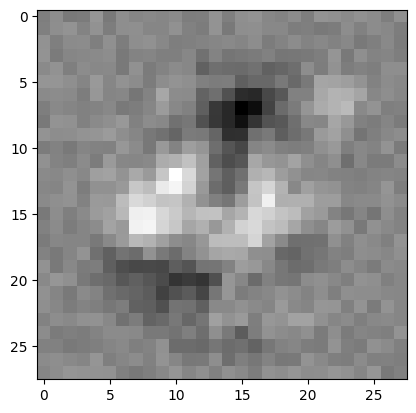

Epoch Accuracy: 0.93
weights: torch.Size([10, 784])


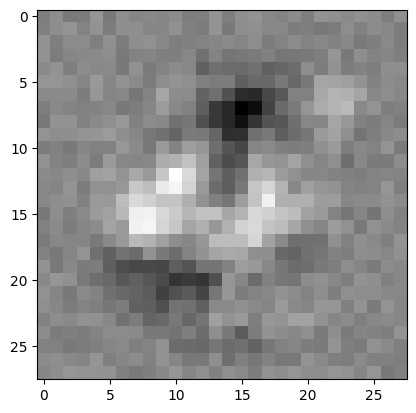

Epoch Accuracy: 0.931
weights: torch.Size([10, 784])


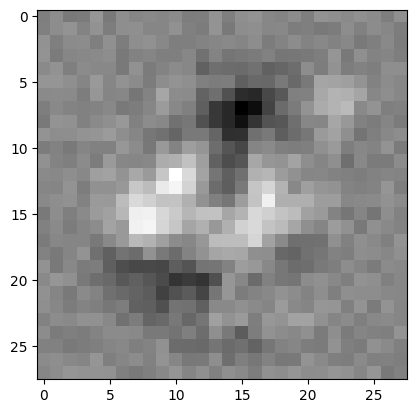

Epoch Accuracy: 0.932
weights: torch.Size([10, 784])


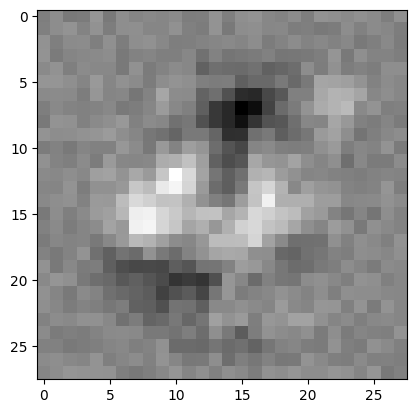

Epoch Accuracy: 0.932
weights: torch.Size([10, 784])


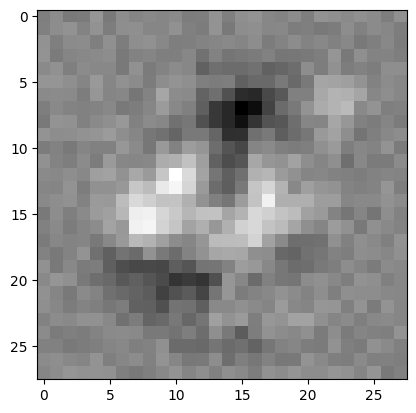

Epoch Accuracy: 0.932
weights: torch.Size([10, 784])


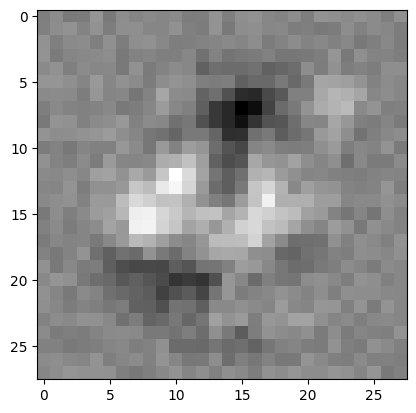

Epoch Accuracy: 0.933
weights: torch.Size([10, 784])


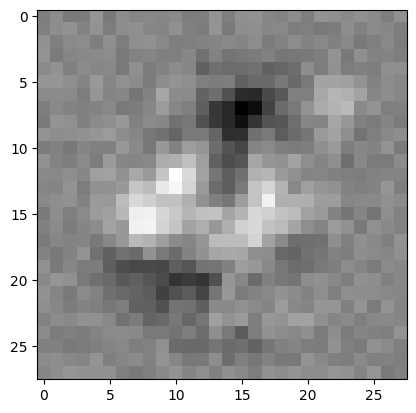

Epoch Accuracy: 0.933
weights: torch.Size([10, 784])


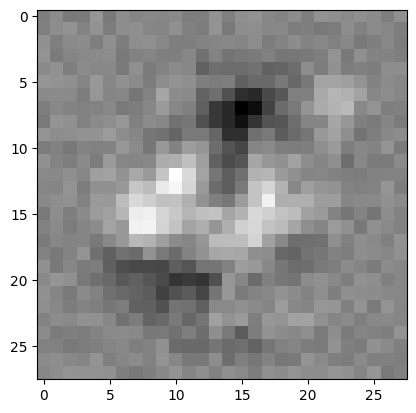

Epoch Accuracy: 0.934
weights: torch.Size([10, 784])


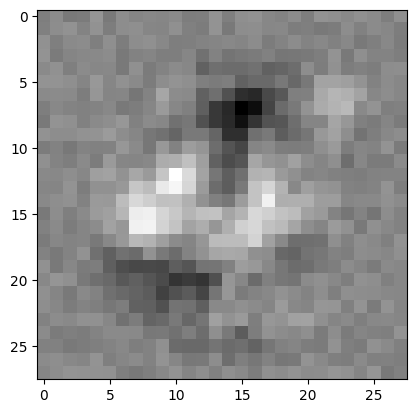

Epoch Accuracy: 0.934
weights: torch.Size([10, 784])


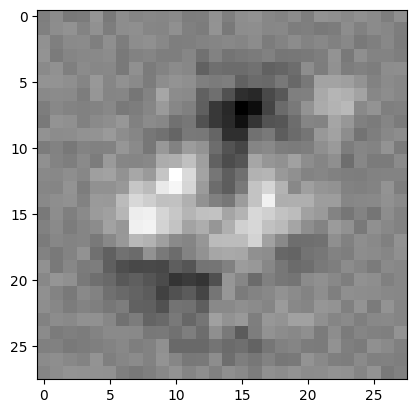

Epoch Accuracy: 0.934
weights: torch.Size([10, 784])


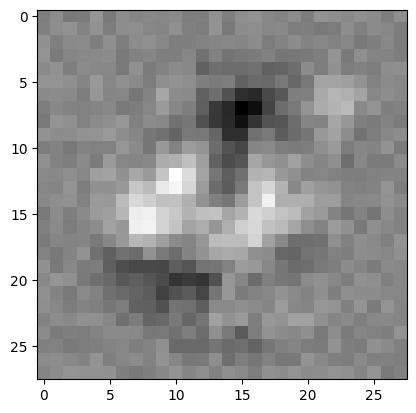

Epoch Accuracy: 0.934
weights: torch.Size([10, 784])


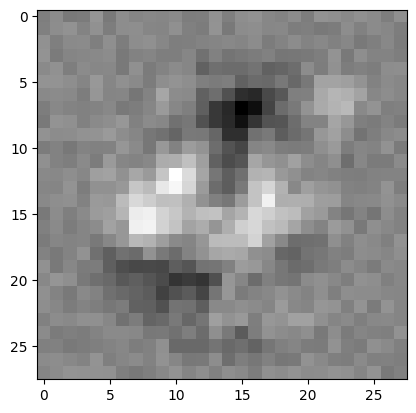

Epoch Accuracy: 0.935
weights: torch.Size([10, 784])


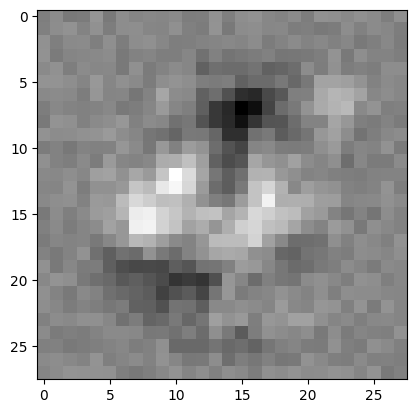

Epoch Accuracy: 0.936
weights: torch.Size([10, 784])


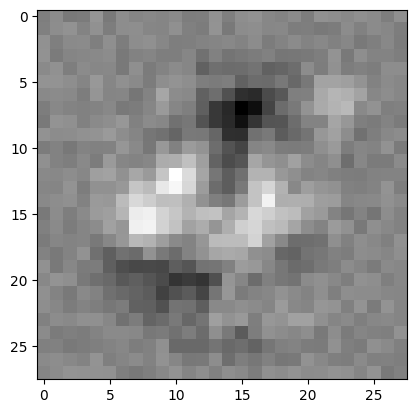

Epoch Accuracy: 0.936
weights: torch.Size([10, 784])


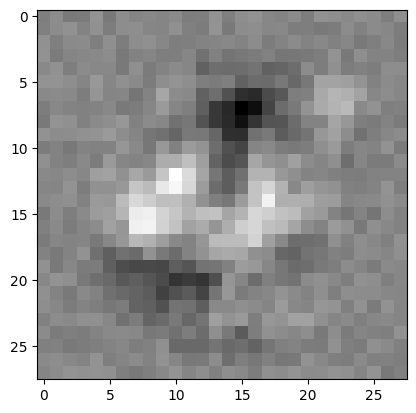

Epoch Accuracy: 0.937
weights: torch.Size([10, 784])


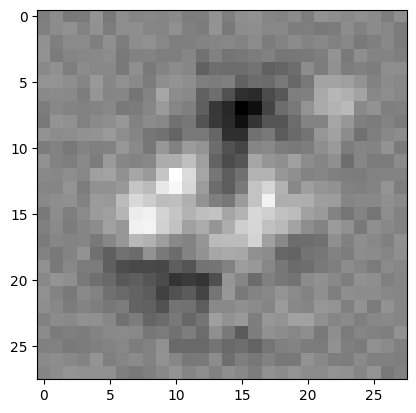

Epoch Accuracy: 0.939
weights: torch.Size([10, 784])


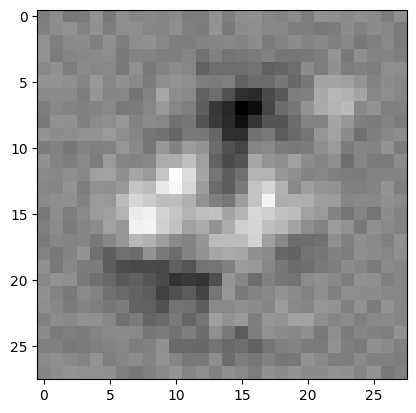

Epoch Accuracy: 0.939
weights: torch.Size([10, 784])


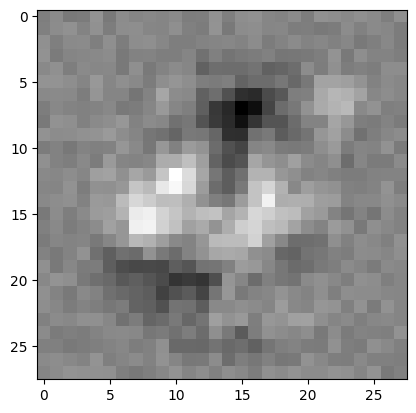

Epoch Accuracy: 0.939
weights: torch.Size([10, 784])


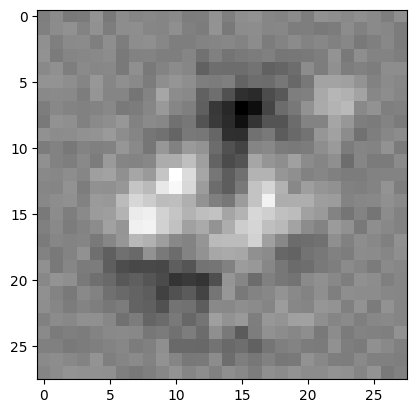

Epoch Accuracy: 0.939
weights: torch.Size([10, 784])


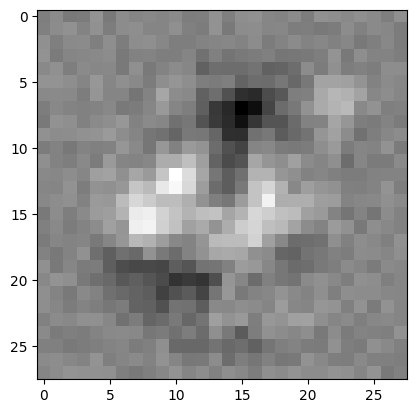

Epoch Accuracy: 0.939
weights: torch.Size([10, 784])


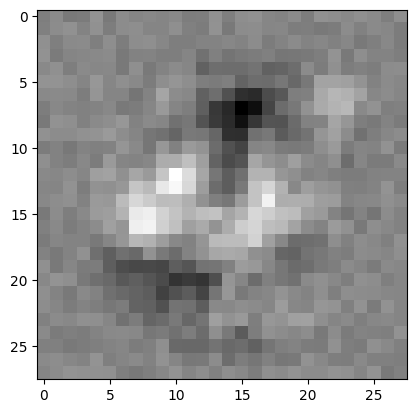

Epoch Accuracy: 0.94
weights: torch.Size([10, 784])


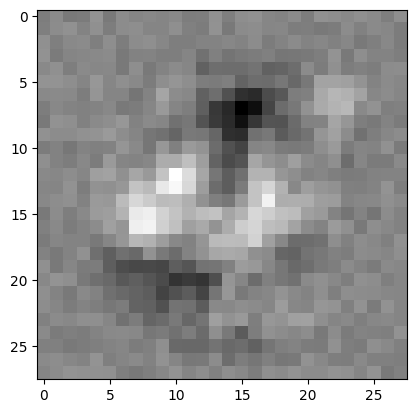

Epoch Accuracy: 0.94
weights: torch.Size([10, 784])


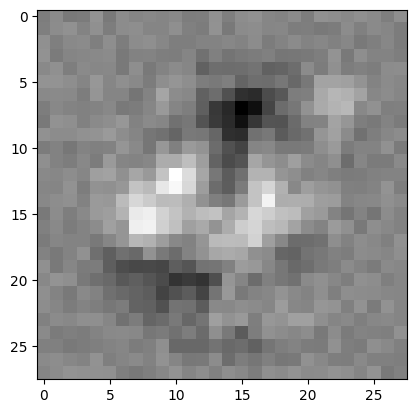

Epoch Accuracy: 0.94
weights: torch.Size([10, 784])


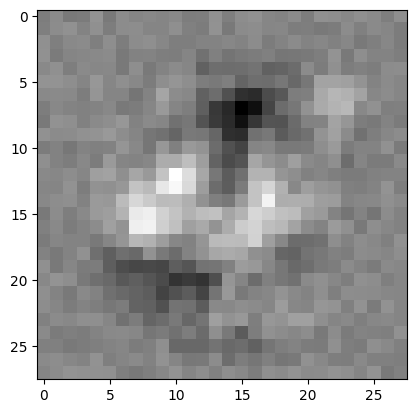

Epoch Accuracy: 0.942
weights: torch.Size([10, 784])


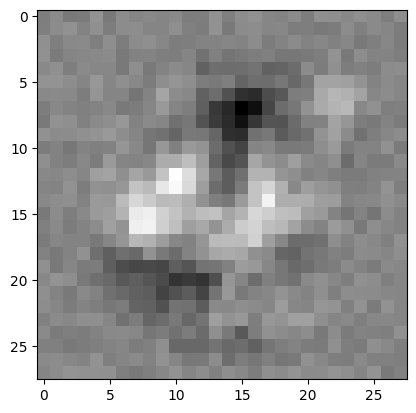

Epoch Accuracy: 0.942
weights: torch.Size([10, 784])


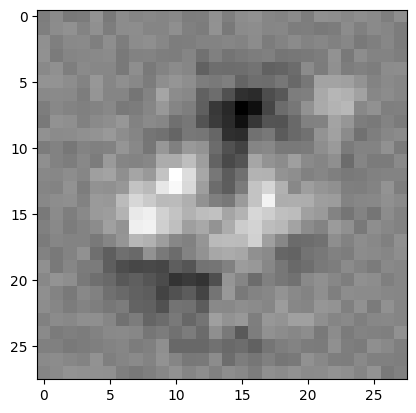

Epoch Accuracy: 0.942
weights: torch.Size([10, 784])


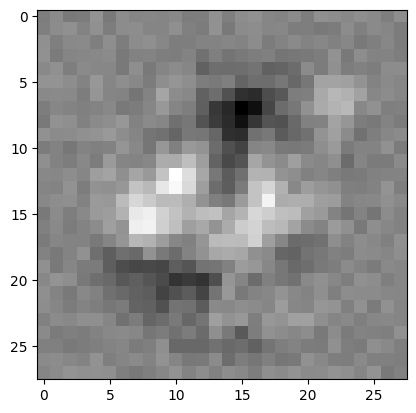

Epoch Accuracy: 0.942


In [18]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print("Epoch Accuracy: " + str(accuracy))

In [19]:
print('Final loss:', loss.item())

Final loss: 0.263337105512619


### Visualizando gráfico de perda durante o treinamento

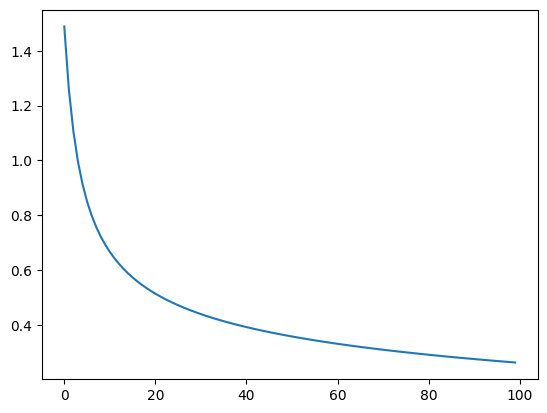

In [20]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [21]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.942


### Matriz de confusão com dados de treinamento e teste

In [22]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,1,3,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,1,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,1,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


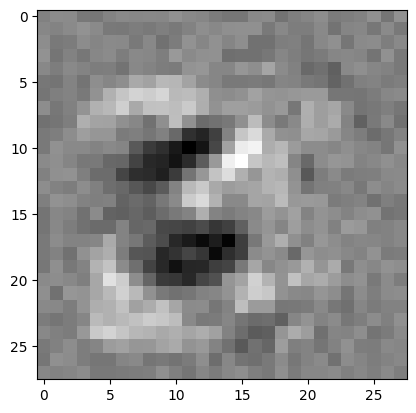

In [23]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

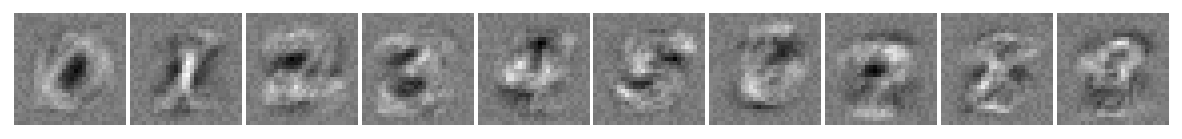

In [24]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

1) Insira código no laço do treinamento para que no final de cada época, seja impresso: o número da época e a perda e a acurácia.

In [27]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Impressão dos resultados ao final da época
    print(f"Época {i + 1}/{epochs}: Perda: {loss.item():.4f} - Acurácia: {accuracy:.4f}")

Época 1/100: Perda: 0.1335 - Acurácia: 0.9790
Época 2/100: Perda: 0.1332 - Acurácia: 0.9790
Época 3/100: Perda: 0.1329 - Acurácia: 0.9790
Época 4/100: Perda: 0.1325 - Acurácia: 0.9790
Época 5/100: Perda: 0.1322 - Acurácia: 0.9790
Época 6/100: Perda: 0.1319 - Acurácia: 0.9790
Época 7/100: Perda: 0.1316 - Acurácia: 0.9790
Época 8/100: Perda: 0.1312 - Acurácia: 0.9790
Época 9/100: Perda: 0.1309 - Acurácia: 0.9790
Época 10/100: Perda: 0.1306 - Acurácia: 0.9790
Época 11/100: Perda: 0.1303 - Acurácia: 0.9790
Época 12/100: Perda: 0.1299 - Acurácia: 0.9790
Época 13/100: Perda: 0.1296 - Acurácia: 0.9790
Época 14/100: Perda: 0.1293 - Acurácia: 0.9790
Época 15/100: Perda: 0.1290 - Acurácia: 0.9790
Época 16/100: Perda: 0.1287 - Acurácia: 0.9790
Época 17/100: Perda: 0.1283 - Acurácia: 0.9790
Época 18/100: Perda: 0.1280 - Acurácia: 0.9790
Época 19/100: Perda: 0.1277 - Acurácia: 0.9790
Época 20/100: Perda: 0.1274 - Acurácia: 0.9800
Época 21/100: Perda: 0.1271 - Acurácia: 0.9800
Época 22/100: Perda: 0

2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Epoch[1/100], loss: 0.106141, acc: 0.990000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


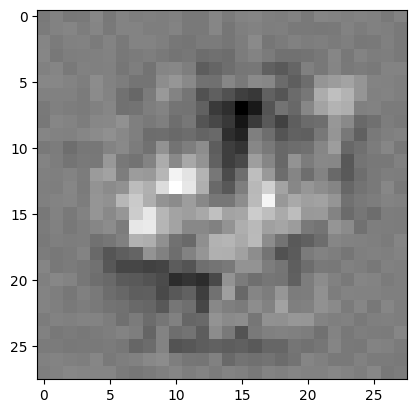

Epoch[2/100], loss: 0.105919, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


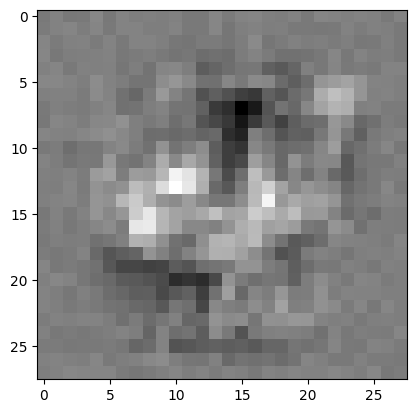

Epoch[3/100], loss: 0.105697, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


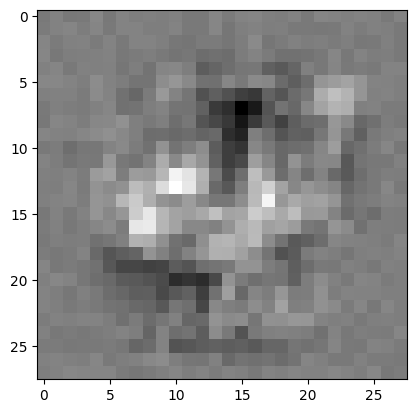

Epoch[4/100], loss: 0.105477, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


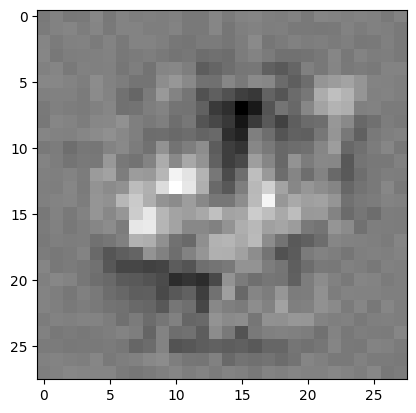

Epoch[5/100], loss: 0.105257, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


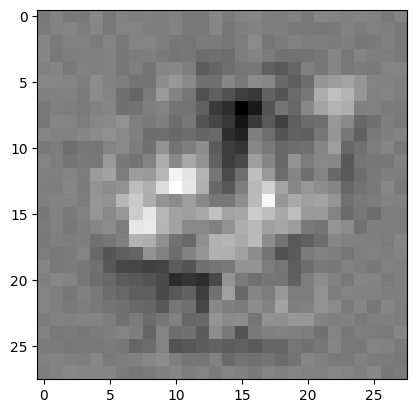

Epoch[6/100], loss: 0.105038, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


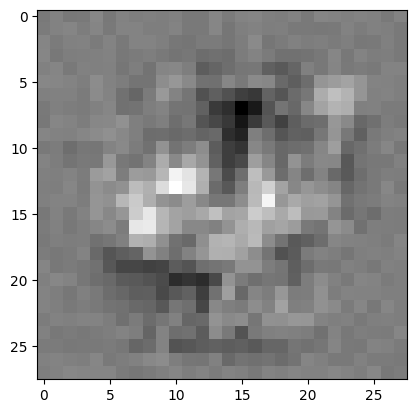

Epoch[7/100], loss: 0.104820, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


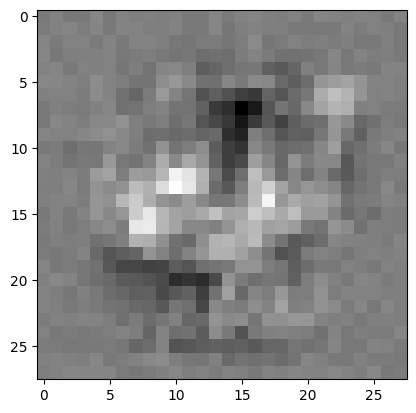

Epoch[8/100], loss: 0.104603, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


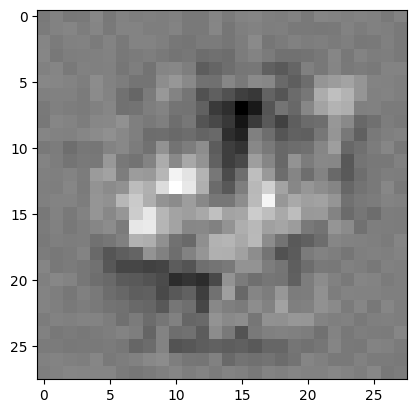

Epoch[9/100], loss: 0.104387, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


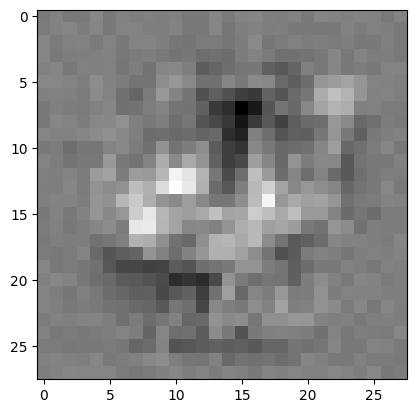

Epoch[10/100], loss: 0.104171, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


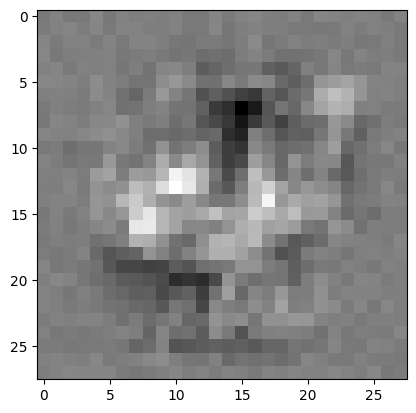

Epoch[11/100], loss: 0.103956, acc: 0.991000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


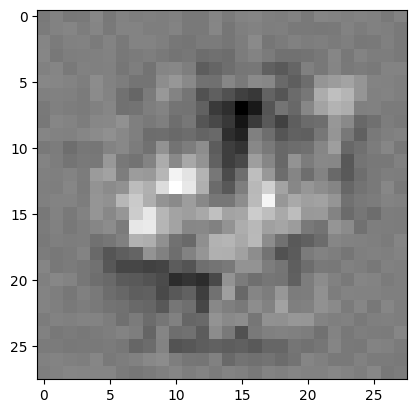

Epoch[12/100], loss: 0.103742, acc: 0.992000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


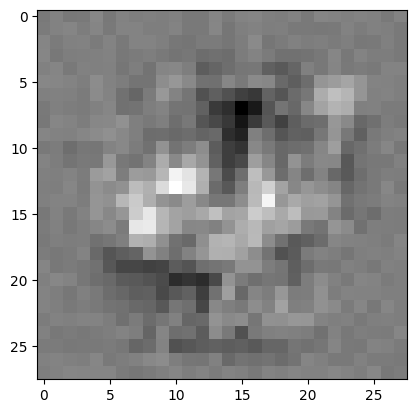

Epoch[13/100], loss: 0.103529, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


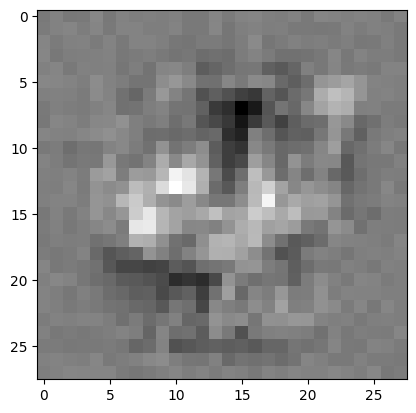

Epoch[14/100], loss: 0.103316, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


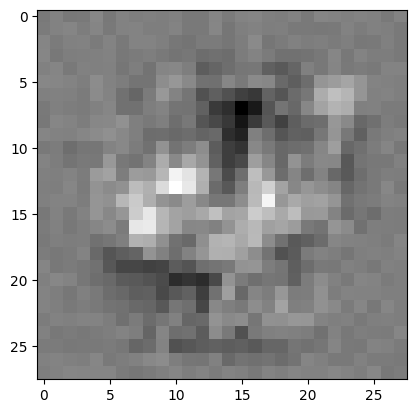

Epoch[15/100], loss: 0.103105, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


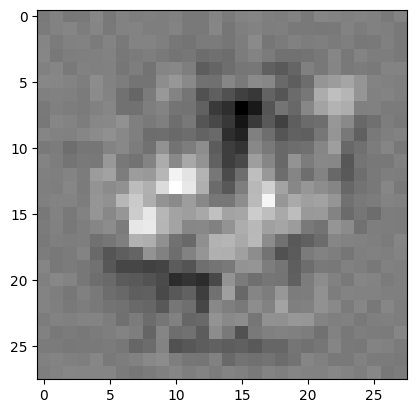

Epoch[16/100], loss: 0.102894, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


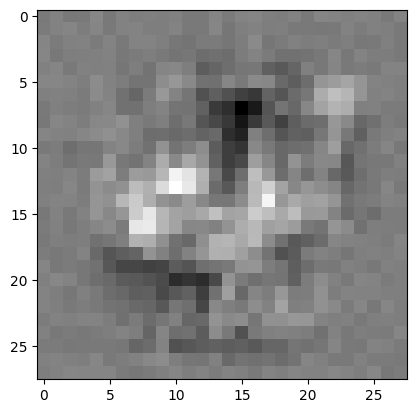

Epoch[17/100], loss: 0.102684, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


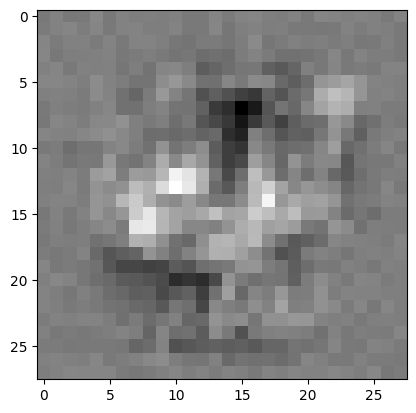

Epoch[18/100], loss: 0.102475, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


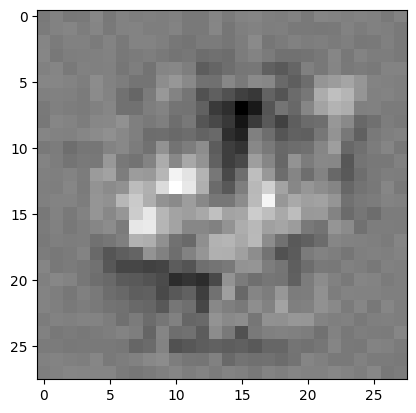

Epoch[19/100], loss: 0.102266, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


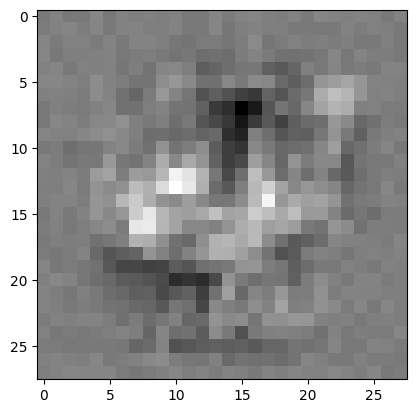

Epoch[20/100], loss: 0.102058, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


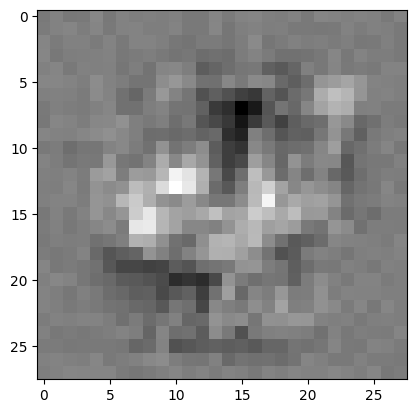

Epoch[21/100], loss: 0.101851, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


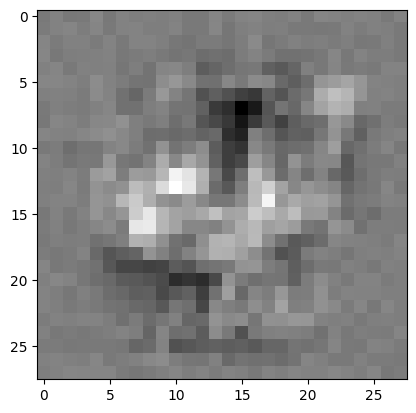

Epoch[22/100], loss: 0.101645, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


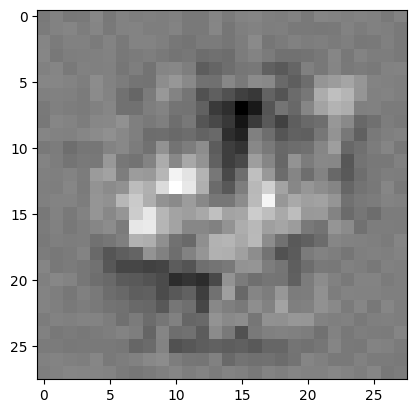

Epoch[23/100], loss: 0.101439, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


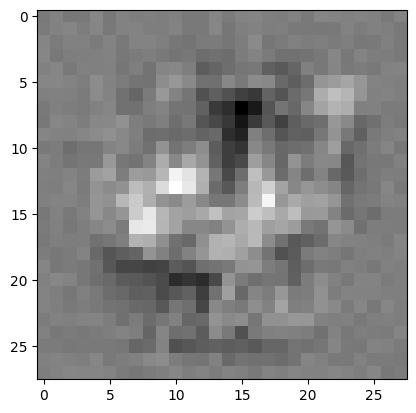

Epoch[24/100], loss: 0.101235, acc: 0.993000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


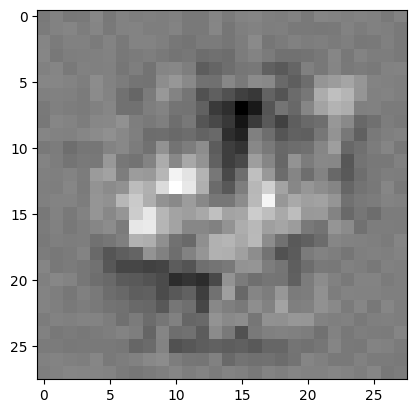

Epoch[25/100], loss: 0.101031, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


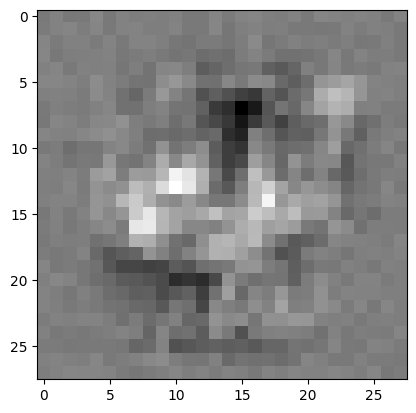

Epoch[26/100], loss: 0.100827, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


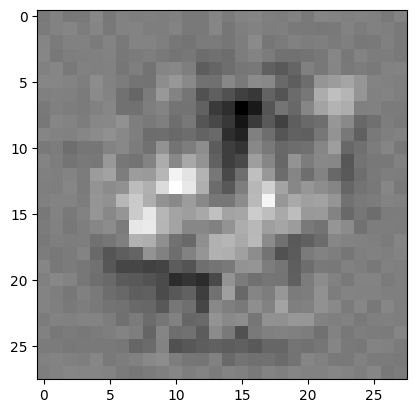

Epoch[27/100], loss: 0.100625, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


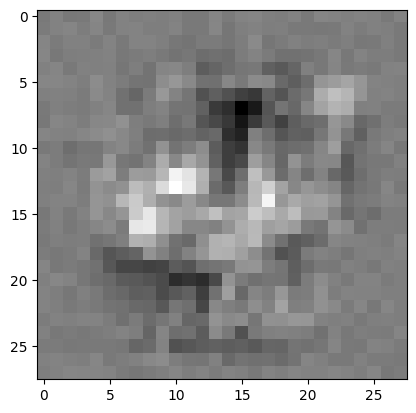

Epoch[28/100], loss: 0.100423, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


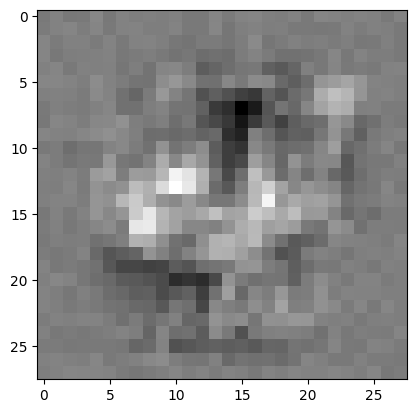

Epoch[29/100], loss: 0.100222, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


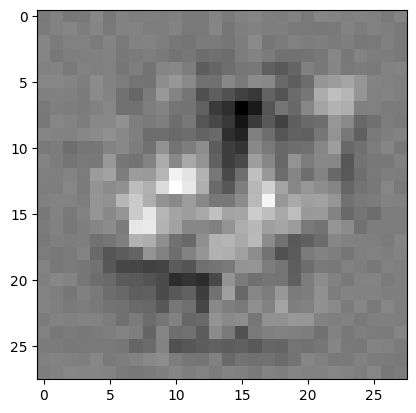

Epoch[30/100], loss: 0.100022, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


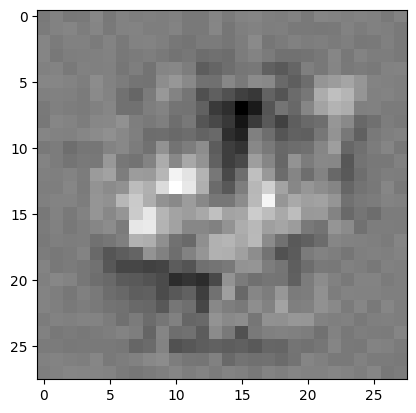

Epoch[31/100], loss: 0.099822, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


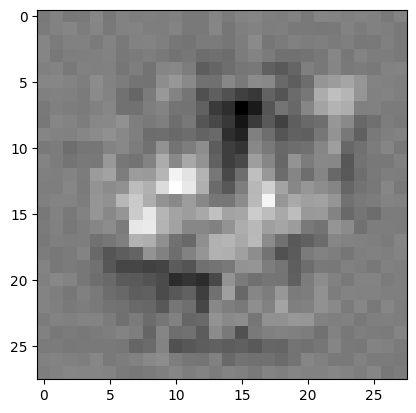

Epoch[32/100], loss: 0.099623, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


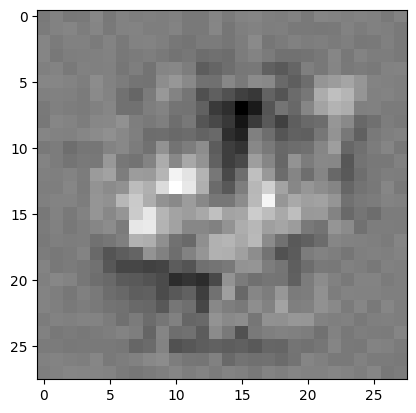

Epoch[33/100], loss: 0.099425, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


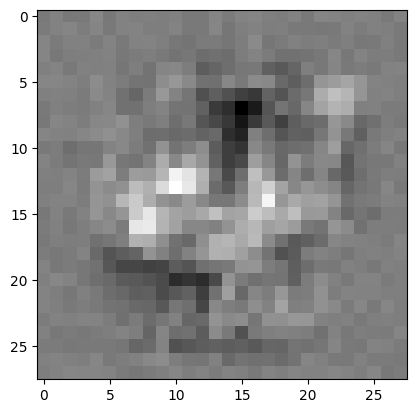

Epoch[34/100], loss: 0.099227, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


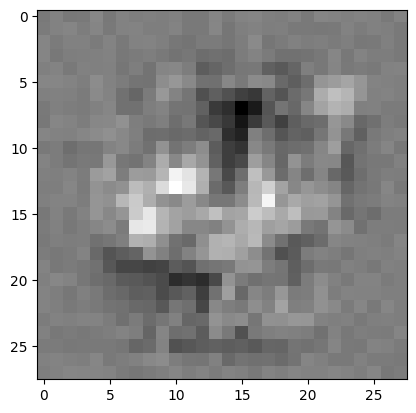

Epoch[35/100], loss: 0.099031, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


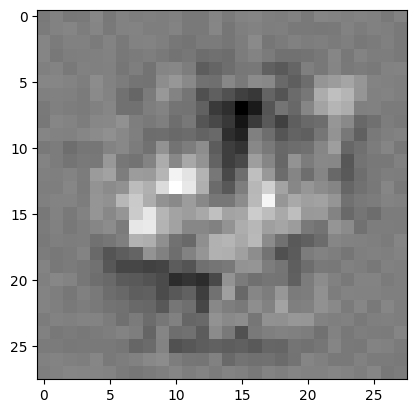

Epoch[36/100], loss: 0.098835, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


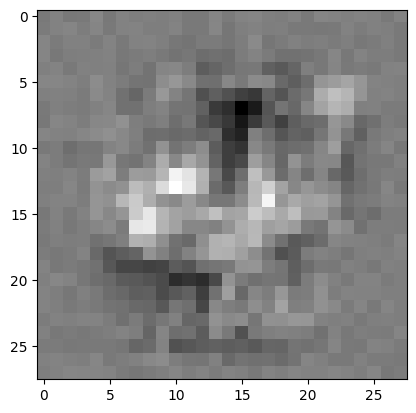

Epoch[37/100], loss: 0.098639, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


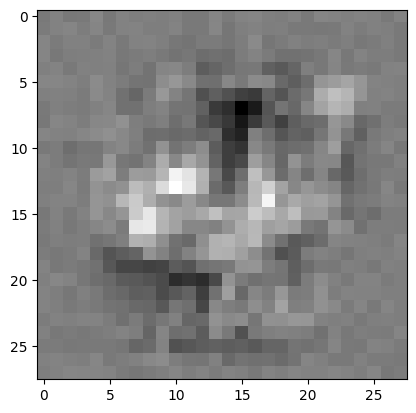

Epoch[38/100], loss: 0.098445, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


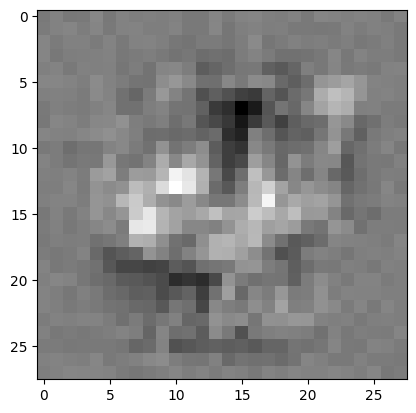

Epoch[39/100], loss: 0.098251, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


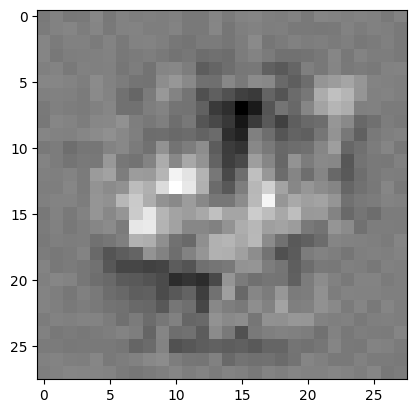

Epoch[40/100], loss: 0.098057, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


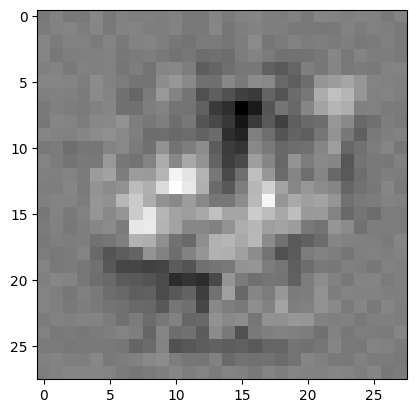

Epoch[41/100], loss: 0.097865, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


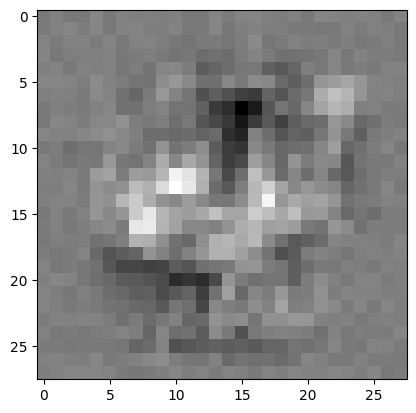

Epoch[42/100], loss: 0.097673, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


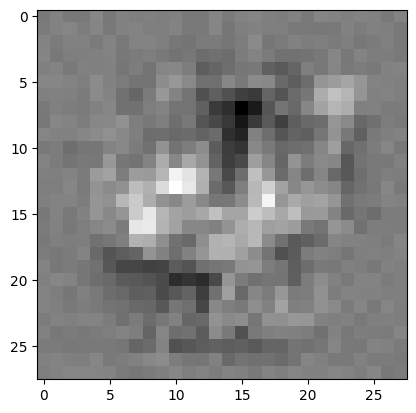

Epoch[43/100], loss: 0.097482, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


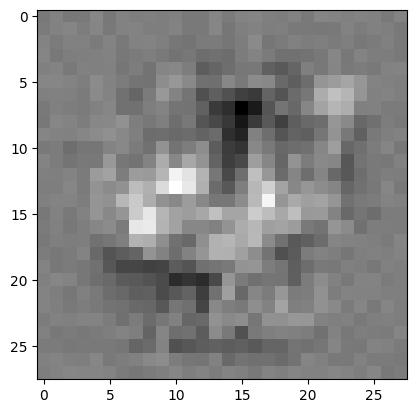

Epoch[44/100], loss: 0.097291, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


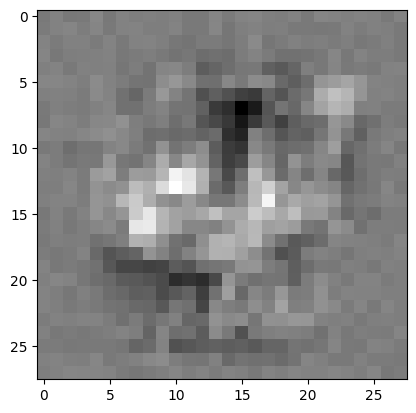

Epoch[45/100], loss: 0.097101, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


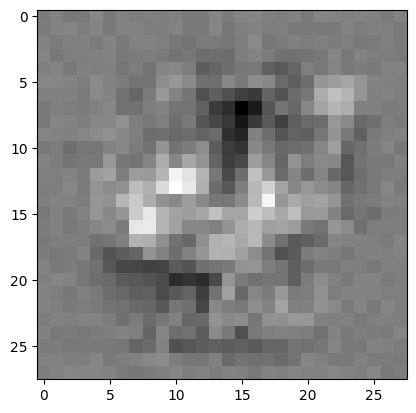

Epoch[46/100], loss: 0.096912, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


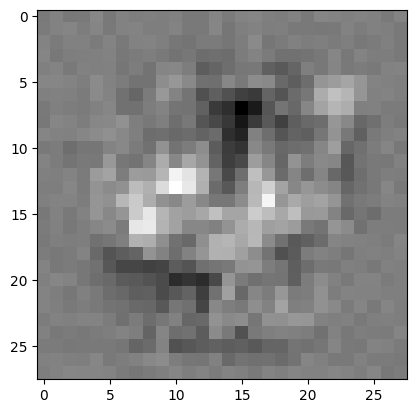

Epoch[47/100], loss: 0.096723, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


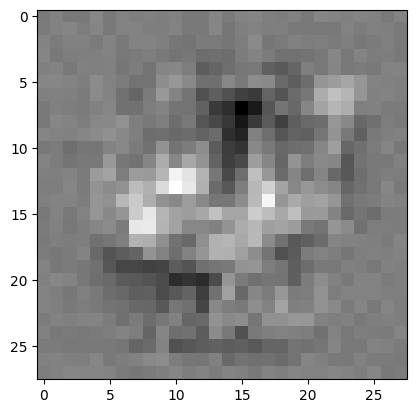

Epoch[48/100], loss: 0.096536, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


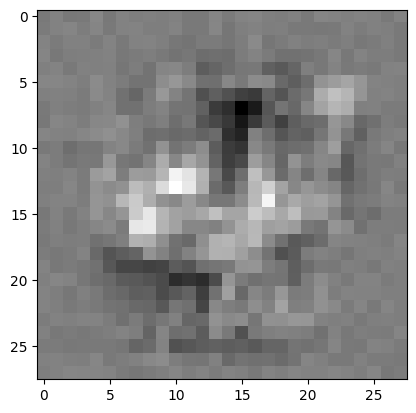

Epoch[49/100], loss: 0.096348, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


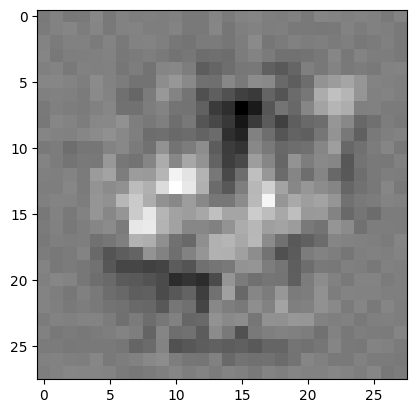

Epoch[50/100], loss: 0.096162, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


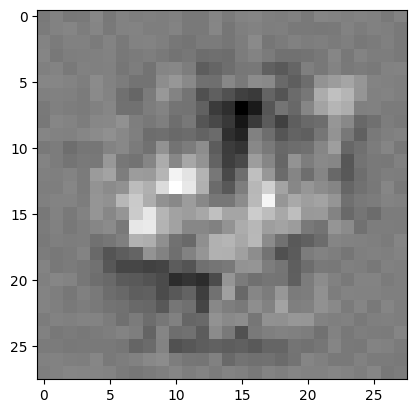

Epoch[51/100], loss: 0.095976, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


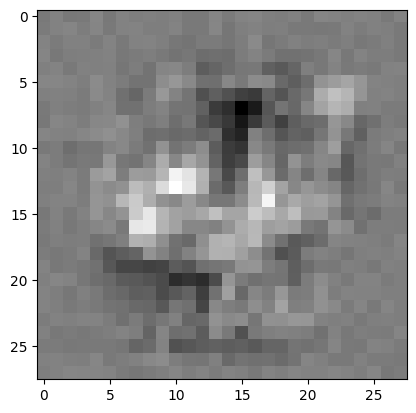

Epoch[52/100], loss: 0.095791, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


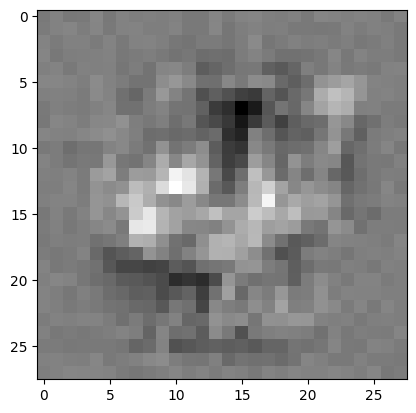

Epoch[53/100], loss: 0.095606, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


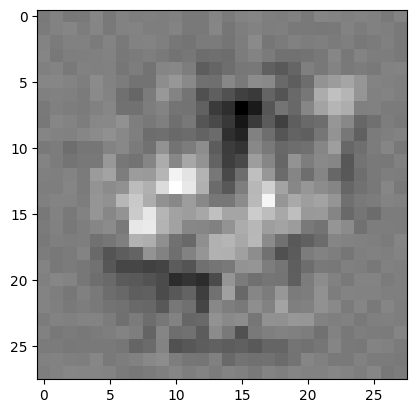

Epoch[54/100], loss: 0.095422, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


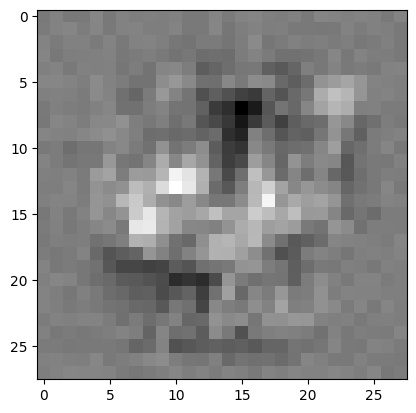

Epoch[55/100], loss: 0.095239, acc: 0.994000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


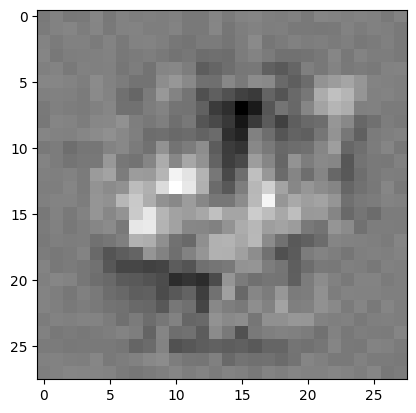

Epoch[56/100], loss: 0.095056, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


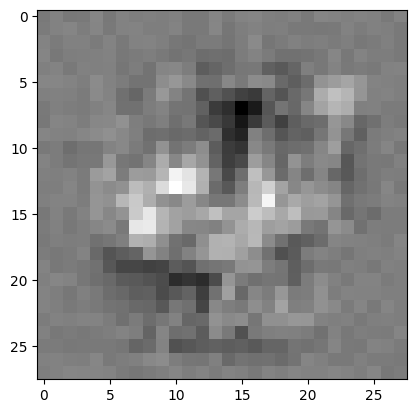

Epoch[57/100], loss: 0.094874, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


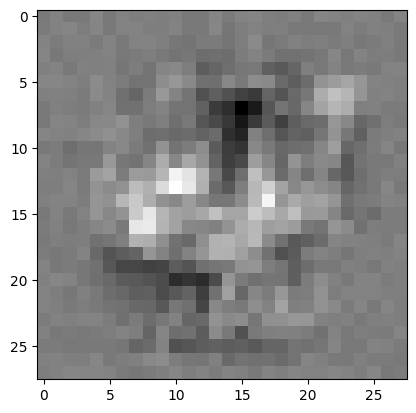

Epoch[58/100], loss: 0.094693, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


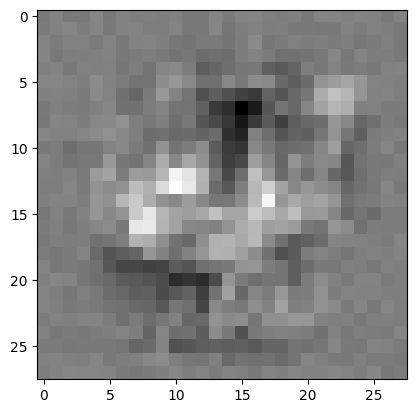

Epoch[59/100], loss: 0.094512, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


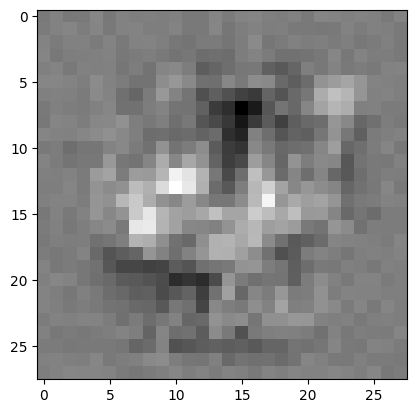

Epoch[60/100], loss: 0.094332, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


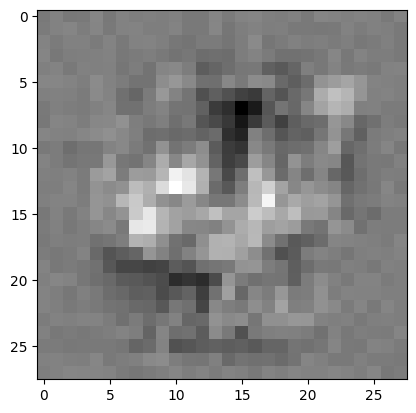

Epoch[61/100], loss: 0.094152, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


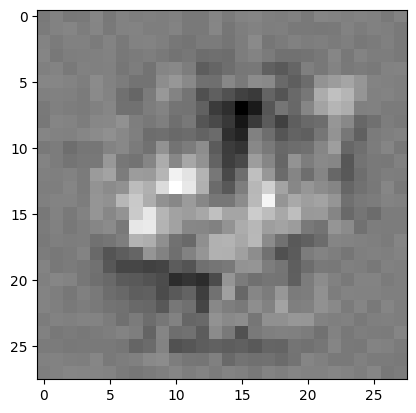

Epoch[62/100], loss: 0.093973, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


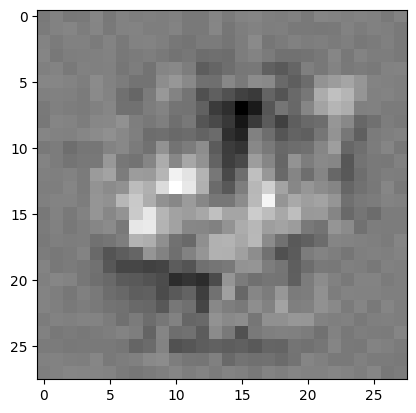

Epoch[63/100], loss: 0.093795, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


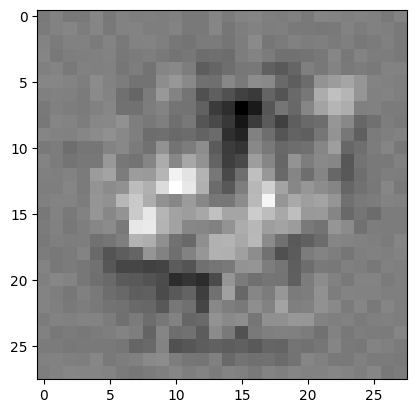

Epoch[64/100], loss: 0.093617, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


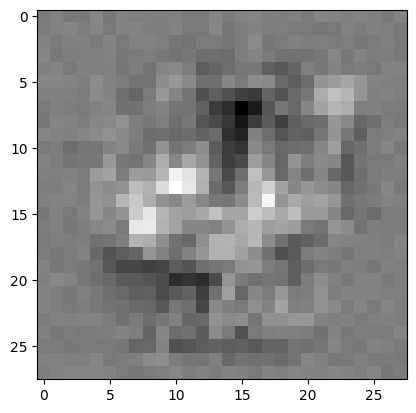

Epoch[65/100], loss: 0.093440, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


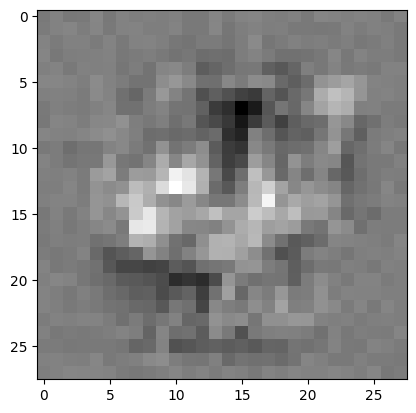

Epoch[66/100], loss: 0.093264, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


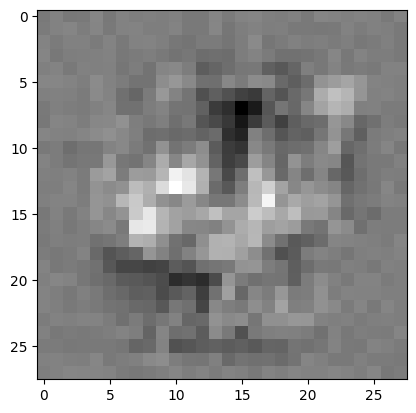

Epoch[67/100], loss: 0.093088, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


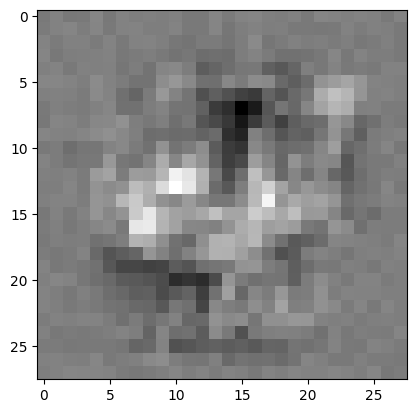

Epoch[68/100], loss: 0.092913, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


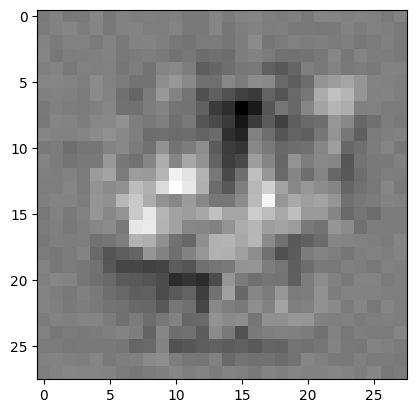

Epoch[69/100], loss: 0.092738, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


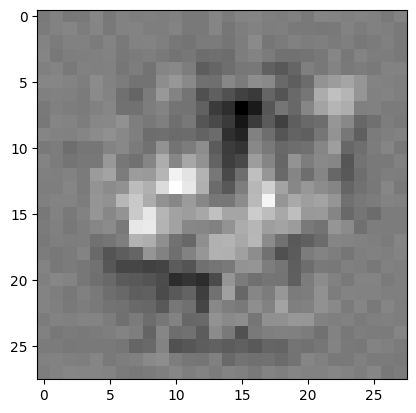

Epoch[70/100], loss: 0.092564, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


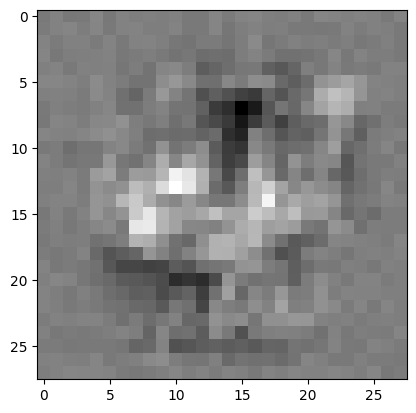

Epoch[71/100], loss: 0.092391, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


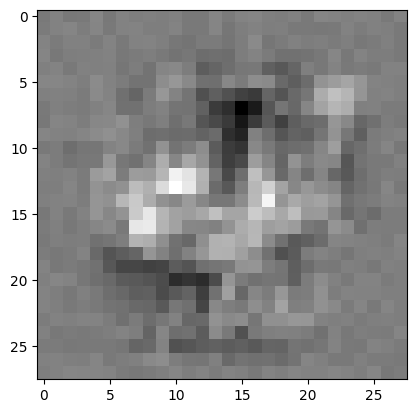

Epoch[72/100], loss: 0.092218, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


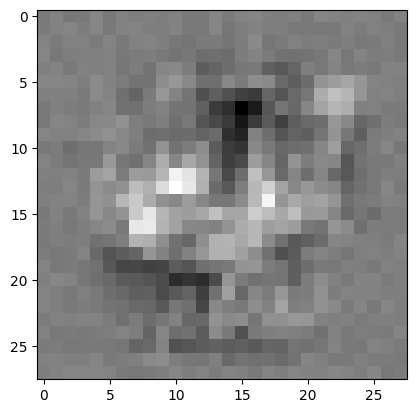

Epoch[73/100], loss: 0.092045, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


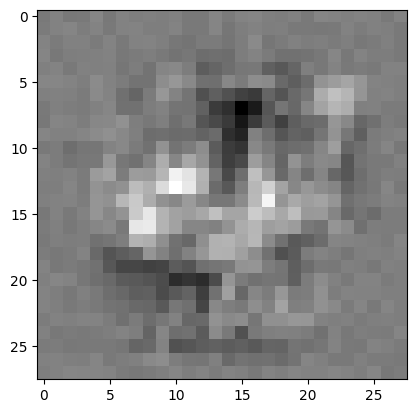

Epoch[74/100], loss: 0.091874, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


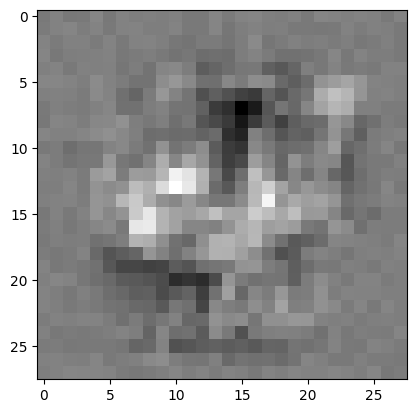

Epoch[75/100], loss: 0.091703, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


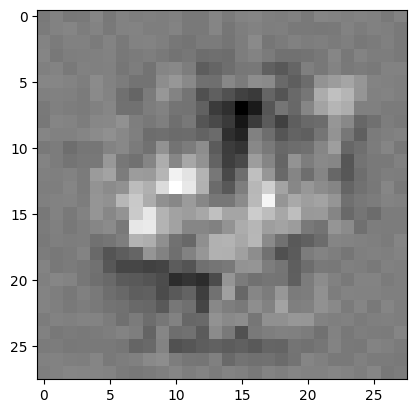

Epoch[76/100], loss: 0.091532, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


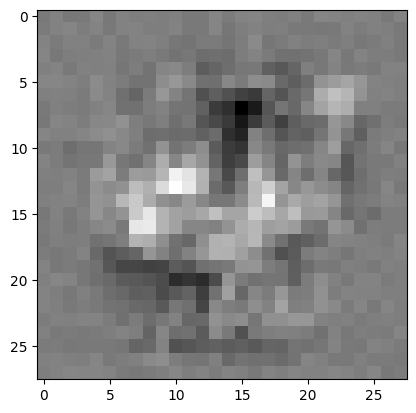

Epoch[77/100], loss: 0.091362, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


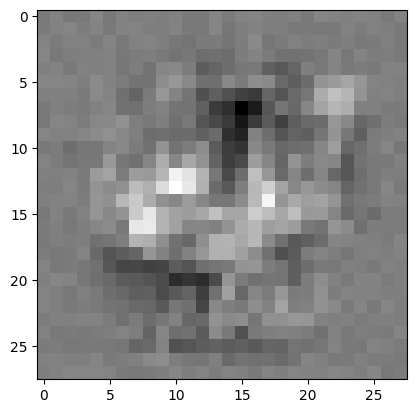

Epoch[78/100], loss: 0.091193, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


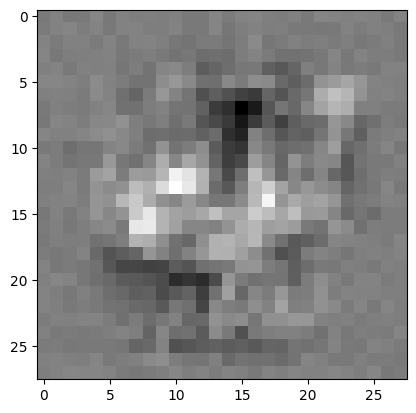

Epoch[79/100], loss: 0.091024, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


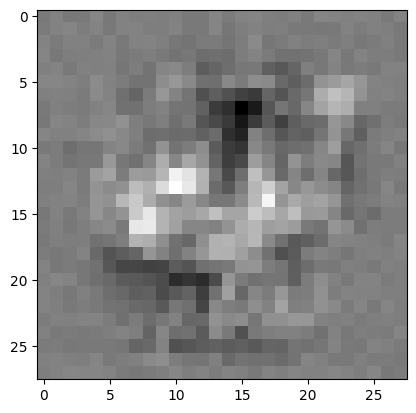

Epoch[80/100], loss: 0.090856, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


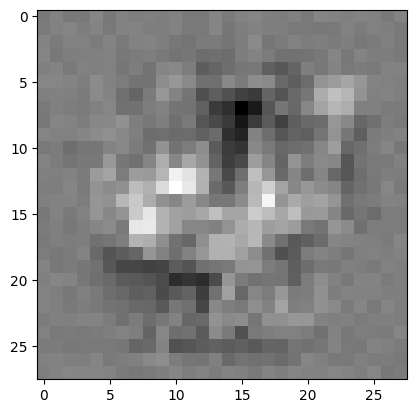

Epoch[81/100], loss: 0.090688, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


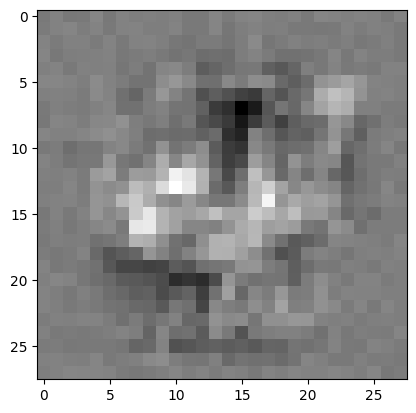

Epoch[82/100], loss: 0.090521, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


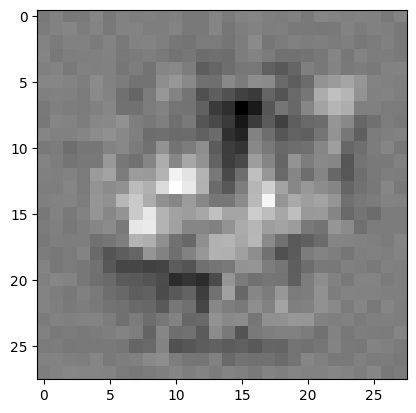

Epoch[83/100], loss: 0.090354, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


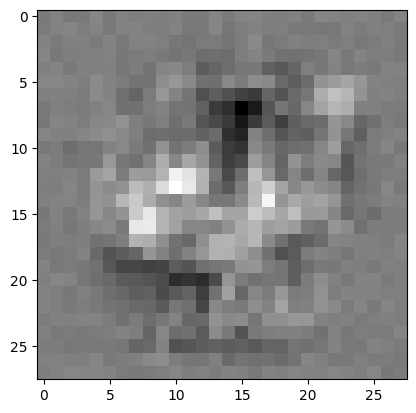

Epoch[84/100], loss: 0.090188, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


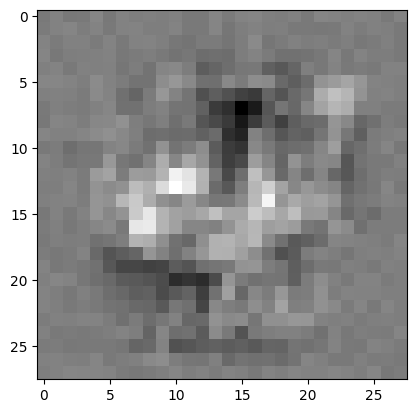

Epoch[85/100], loss: 0.090023, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


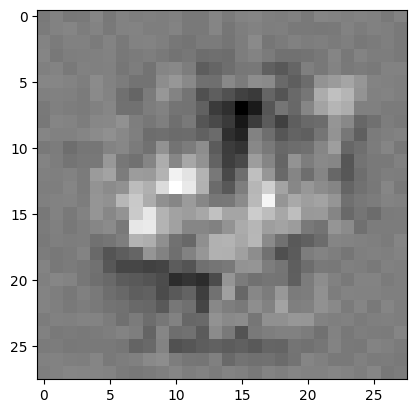

Epoch[86/100], loss: 0.089858, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


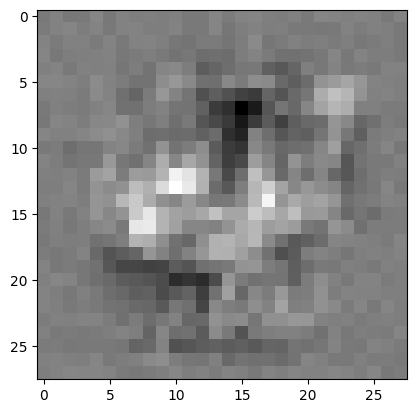

Epoch[87/100], loss: 0.089694, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


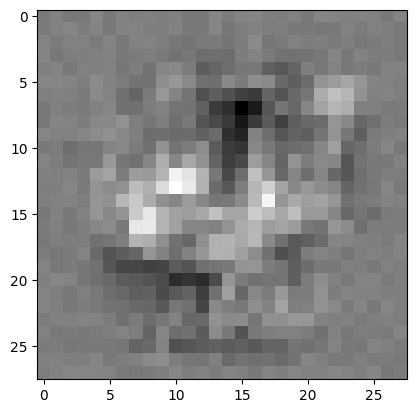

Epoch[88/100], loss: 0.089530, acc: 0.995000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


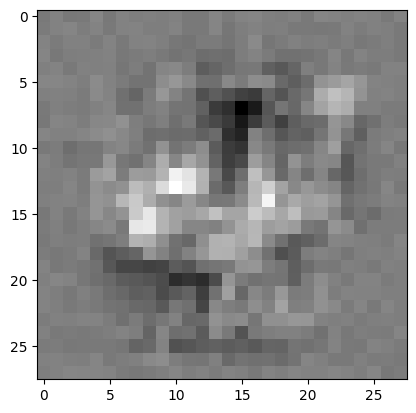

Epoch[89/100], loss: 0.089367, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


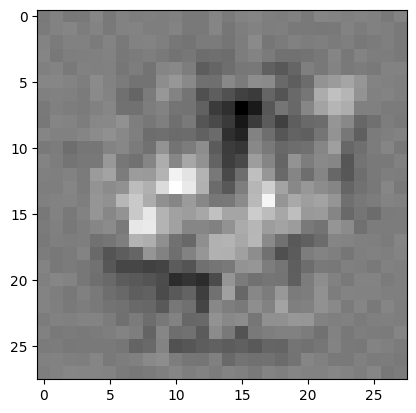

Epoch[90/100], loss: 0.089204, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


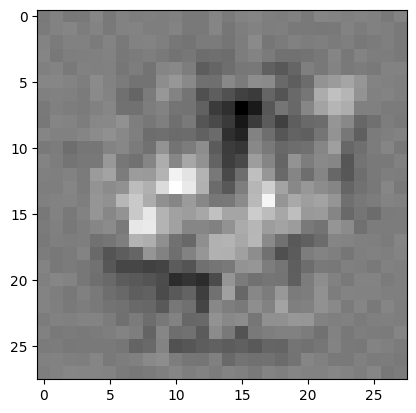

Epoch[91/100], loss: 0.089042, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


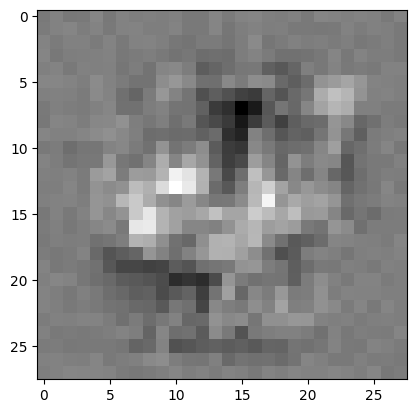

Epoch[92/100], loss: 0.088880, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


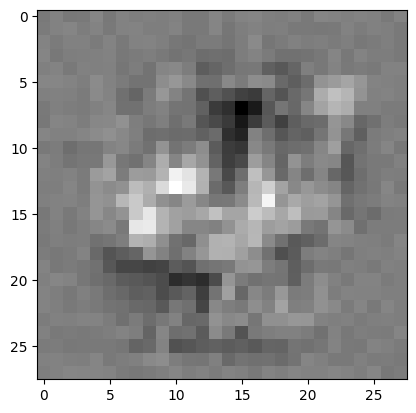

Epoch[93/100], loss: 0.088719, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


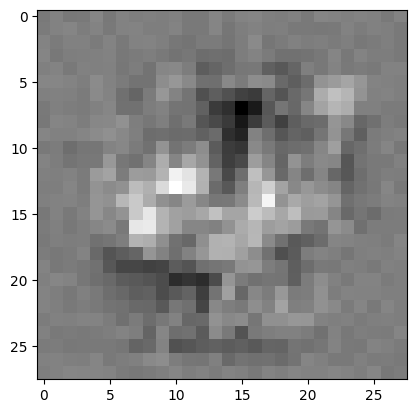

Epoch[94/100], loss: 0.088559, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


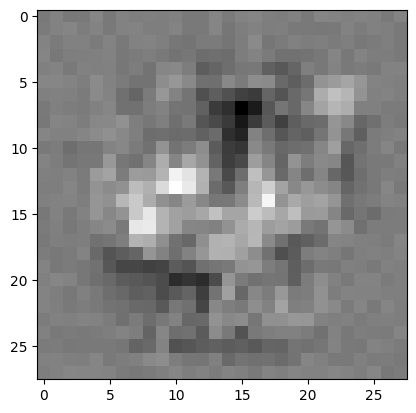

Epoch[95/100], loss: 0.088399, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


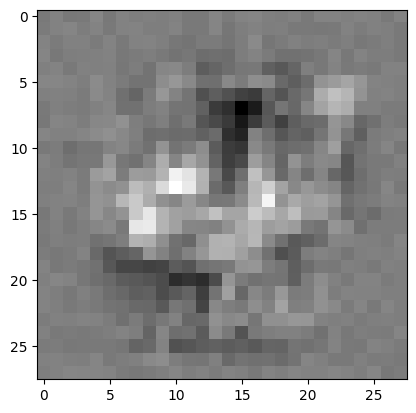

Epoch[96/100], loss: 0.088239, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


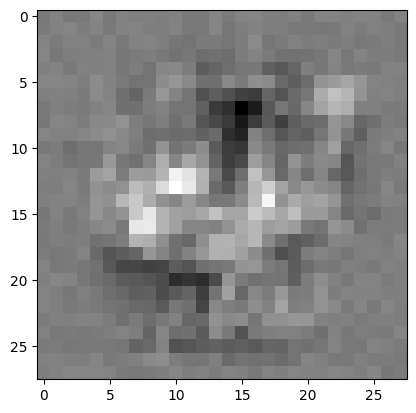

Epoch[97/100], loss: 0.088080, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


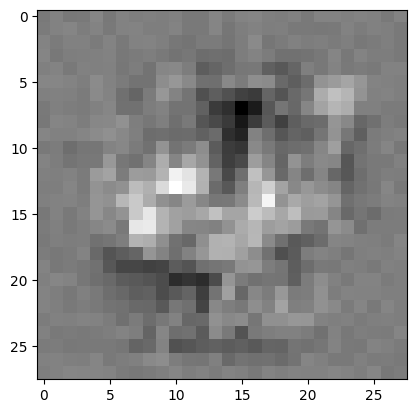

Epoch[98/100], loss: 0.087922, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


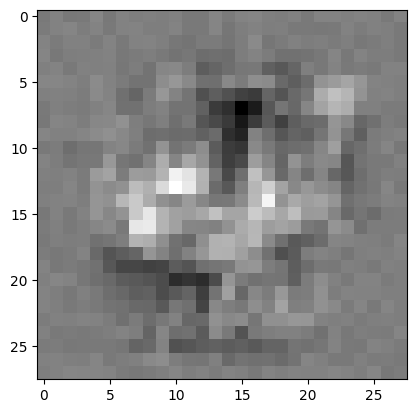

Epoch[99/100], loss: 0.087764, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


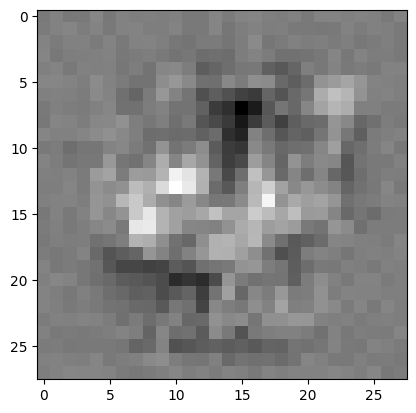

Epoch[100/100], loss: 0.087606, acc: 0.996000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


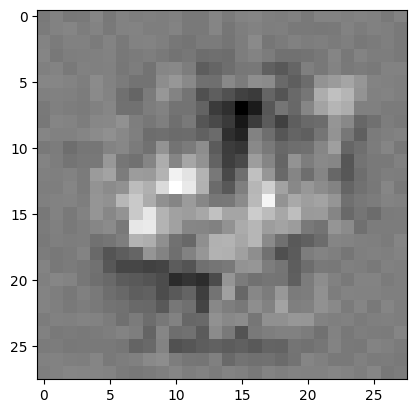

In [28]:

import numpy

losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
- [1000, 28, 28]

2. Qual é o shape da saída da rede?
- [1000, 10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?
- 28 x 28 x 10 + 10 = 7850


# Aprendizados


1. Os atributos são os pixels rasterizados (28x28) para entrada na rede neural
2. Formato de imagem pode ser canal primeiro ou canal último (c,H,W) ou (H,W,c) respectivamente. O PyTorch utiliza formato (amostras, c, H, W). O matplotlib imshow utiliza formato (H,W,c) ou (H,W)
3. Este exemplo permite uma interpretação visual dos pesos (parâmetros treinados)